In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -36]) # Column containing response actual values (temperature) at time t

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    #new_df = new_df.iloc[:180, :]
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df) 

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + 12*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]


Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 1:
12
84
<class 'list'>
12
21
<class 'list'>
(84, 1, 1, 2149)
(11, 1, 1, 2149)
(10, 1, 1, 2149)
(84, 1, 2149)
(11, 1, 2149)
(10, 1, 2149)
(84, 2149)
(11, 2149)
(10, 2149)
[[0.39307412 0.69695044 0.32924264 ... 0.46817877 0.77165354 0.45747266]
 [0.45747266 0.51683609 0.42215989 ... 0.46817877 0.77165354 0.5246051 ]
 [0.38487242 0.62674714 0.3411641  ... 0.46817877 0.77165354 0.4954435 ]
 ...
 [0.54100851 0.46473952 0.46949509 ... 0.46817877 0.77165354 0.4936209 ]
 [0.44896719 0.51620076 0.3997195  ... 0.46817877 0.77165354 0.54009721]
 [0.46780073 0.52414231 0.42356241 ... 0.46817877 0.77165354 0.49696233]]
Fold 2:
12
84
<class 'list'>
12
21
<class 'list'>
(84, 1, 1, 2149)
(11, 1, 1, 2149)
(10, 1, 1, 2149)
(84, 1, 2149)
(11, 1, 2149)
(10, 1, 2149)
(84, 2149)
(11, 2149)
(10, 2149)
[[0.38166311 0.6

In [3]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
179
(84, 2149)
(11, 2149)


In [6]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the CNN-LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    #print("Forecasts:")
    #print(forecasts)
    #print("Actual:")
    #print(actual)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

[I 2025-05-15 19:34:10,787] A new study created in memory with name: no-name-e48d6479-aa9c-49e2-914d-c83ca0c66729
[I 2025-05-15 19:38:34,022] Trial 0 finished with value: 0.14478530287742614 and parameters: {'lr': 0.007287019008030331, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3042787729313313}. Best is trial 0 with value: 0.14478530287742614.


Cross Validation Accuracies:
[0.15542259812355042, 0.15991318225860596, 0.11262461543083191, 0.14034685492515564, 0.15561926364898682]
Mean Cross Validation Accuracy:
0.14478530287742614
Standard Deviation of Cross Validation Accuracy:
0.017397638506343308


[I 2025-05-15 19:42:57,099] Trial 1 finished with value: 0.10361360758543015 and parameters: {'lr': 0.029225822215205206, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.18484494319328806}. Best is trial 1 with value: 0.10361360758543015.


Cross Validation Accuracies:
[0.108682781457901, 0.17424845695495605, 0.1013079360127449, 0.044039927423000336, 0.08978893607854843]
Mean Cross Validation Accuracy:
0.10361360758543015
Standard Deviation of Cross Validation Accuracy:
0.04185794906818707


[I 2025-05-15 19:45:51,918] Trial 2 finished with value: 1.1901501178741456 and parameters: {'lr': 0.05110472303895847, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.14259120651544524}. Best is trial 1 with value: 0.10361360758543015.


Cross Validation Accuracies:
[1.2153640985488892, 0.34916001558303833, 2.8108713626861572, 0.34960776567459106, 1.2257473468780518]
Mean Cross Validation Accuracy:
1.1901501178741456
Standard Deviation of Cross Validation Accuracy:
0.8991569450226125


[I 2025-05-15 19:49:17,429] Trial 3 finished with value: 0.27061803340911866 and parameters: {'lr': 0.02713804494561404, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.46205812112990696}. Best is trial 1 with value: 0.10361360758543015.


Cross Validation Accuracies:
[0.2200775295495987, 0.3165816068649292, 0.20629189908504486, 0.29723984003067017, 0.31289929151535034]
Mean Cross Validation Accuracy:
0.27061803340911866
Standard Deviation of Cross Validation Accuracy:
0.04754212773345698


[I 2025-05-15 19:52:54,353] Trial 4 finished with value: 0.06661494597792625 and parameters: {'lr': 0.15268942007696096, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17298512109745767}. Best is trial 4 with value: 0.06661494597792625.


Cross Validation Accuracies:
[0.06535368412733078, 0.0558982752263546, 0.06510338932275772, 0.07153917849063873, 0.07518020272254944]
Mean Cross Validation Accuracy:
0.06661494597792625
Standard Deviation of Cross Validation Accuracy:
0.006577755026081631


[I 2025-05-15 19:59:31,050] Trial 5 finished with value: 0.03757935389876366 and parameters: {'lr': 0.0014338199270925456, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.14667820549140345}. Best is trial 5 with value: 0.03757935389876366.


Cross Validation Accuracies:
[0.041792500764131546, 0.022983767092227936, 0.03137398138642311, 0.0483194924890995, 0.04342702776193619]
Mean Cross Validation Accuracy:
0.03757935389876366
Standard Deviation of Cross Validation Accuracy:
0.009152423452865835


[I 2025-05-15 20:04:56,664] Trial 6 finished with value: 0.03701727390289307 and parameters: {'lr': 0.004409452580548986, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4144705451041575}. Best is trial 6 with value: 0.03701727390289307.


Cross Validation Accuracies:
[0.018843363970518112, 0.042816586792469025, 0.02418484538793564, 0.06023687124252319, 0.03900470212101936]
Mean Cross Validation Accuracy:
0.03701727390289307
Standard Deviation of Cross Validation Accuracy:
0.014640313011336434


[I 2025-05-15 20:08:16,905] Trial 7 finished with value: 0.03011928088963032 and parameters: {'lr': 0.0026458713154954225, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4495363440092456}. Best is trial 7 with value: 0.03011928088963032.


Cross Validation Accuracies:
[0.024997800588607788, 0.02541661262512207, 0.03298068419098854, 0.040810905396938324, 0.026390401646494865]
Mean Cross Validation Accuracy:
0.03011928088963032
Standard Deviation of Cross Validation Accuracy:
0.006078612557943699


[I 2025-05-15 20:12:38,115] Trial 8 finished with value: 0.053740938752889635 and parameters: {'lr': 0.10557937827013174, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2542646683299714}. Best is trial 7 with value: 0.03011928088963032.


Cross Validation Accuracies:
[0.02968541532754898, 0.05714813619852066, 0.06485911458730698, 0.071928970515728, 0.04508305713534355]
Mean Cross Validation Accuracy:
0.053740938752889635
Standard Deviation of Cross Validation Accuracy:
0.01496432055988583


[I 2025-05-15 20:16:57,811] Trial 9 finished with value: 12.88390941619873 and parameters: {'lr': 0.13379433261068222, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.16029325805852734}. Best is trial 7 with value: 0.03011928088963032.


Cross Validation Accuracies:
[14.912705421447754, 10.893811225891113, 12.0442476272583, 15.605034828186035, 10.96374797821045]
Mean Cross Validation Accuracy:
12.88390941619873
Standard Deviation of Cross Validation Accuracy:
1.9936438705790456


[I 2025-05-15 20:20:07,277] Trial 10 finished with value: 52.322492599487305 and parameters: {'lr': 0.8120504584010437, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.36811164357108295}. Best is trial 7 with value: 0.03011928088963032.


Cross Validation Accuracies:
[29.873991012573242, 49.28437805175781, 36.41727828979492, 61.0475959777832, 84.98921966552734]
Mean Cross Validation Accuracy:
52.322492599487305
Standard Deviation of Cross Validation Accuracy:
19.541666724766113


[I 2025-05-15 20:23:04,613] Trial 11 finished with value: 0.02911948449909687 and parameters: {'lr': 0.001153928954067484, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4884243020394776}. Best is trial 11 with value: 0.02911948449909687.


Cross Validation Accuracies:
[0.02251388318836689, 0.03236006200313568, 0.022645222023129463, 0.04098743945360184, 0.02709081582725048]
Mean Cross Validation Accuracy:
0.02911948449909687
Standard Deviation of Cross Validation Accuracy:
0.006942841453266949


[I 2025-05-15 20:26:19,139] Trial 12 finished with value: 0.02416846714913845 and parameters: {'lr': 0.001035697734517649, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4969874537557969}. Best is trial 12 with value: 0.02416846714913845.


Cross Validation Accuracies:
[0.02048063650727272, 0.0185302272439003, 0.03405335545539856, 0.028731347993016243, 0.01904676854610443]
Mean Cross Validation Accuracy:
0.02416846714913845
Standard Deviation of Cross Validation Accuracy:
0.006166888017064832


[I 2025-05-15 20:29:55,100] Trial 13 finished with value: 0.02551289163529873 and parameters: {'lr': 0.0010463954002730548, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.47762360537964377}. Best is trial 12 with value: 0.02416846714913845.


Cross Validation Accuracies:
[0.019769873470067978, 0.02601569890975952, 0.03050151653587818, 0.03096306137740612, 0.020314307883381844]
Mean Cross Validation Accuracy:
0.02551289163529873
Standard Deviation of Cross Validation Accuracy:
0.004792725204799032


[I 2025-05-15 20:33:56,586] Trial 14 finished with value: 0.11003523357212544 and parameters: {'lr': 0.008334015349331769, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.38317636039586844}. Best is trial 12 with value: 0.02416846714913845.


Cross Validation Accuracies:
[0.20328663289546967, 0.024688923731446266, 0.08562315255403519, 0.07698949426412582, 0.15958796441555023]
Mean Cross Validation Accuracy:
0.11003523357212544
Standard Deviation of Cross Validation Accuracy:
0.06344014470234127


[I 2025-05-15 20:43:47,793] Trial 15 finished with value: 0.030303523316979407 and parameters: {'lr': 0.0025170010314747157, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.3419491861980074}. Best is trial 12 with value: 0.02416846714913845.


Cross Validation Accuracies:
[0.02726978249847889, 0.02390214055776596, 0.03057563491165638, 0.042789656668901443, 0.026980401948094368]
Mean Cross Validation Accuracy:
0.030303523316979407
Standard Deviation of Cross Validation Accuracy:
0.0065909330298231554


[I 2025-05-15 20:56:02,474] Trial 16 finished with value: 0.13408039696514606 and parameters: {'lr': 0.011920615759889536, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.4928390118899106}. Best is trial 12 with value: 0.02416846714913845.


Cross Validation Accuracies:
[0.12189476937055588, 0.08862272650003433, 0.3256663978099823, 0.10679639130830765, 0.027421699836850166]
Mean Cross Validation Accuracy:
0.13408039696514606
Standard Deviation of Cross Validation Accuracy:
0.10103522126614488


[I 2025-05-15 21:10:42,563] Trial 17 finished with value: 0.024750928580760955 and parameters: {'lr': 0.0010242232230639739, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4106105300537688}. Best is trial 12 with value: 0.02416846714913845.


Cross Validation Accuracies:
[0.020874984562397003, 0.024045856669545174, 0.027396120131015778, 0.031559403985738754, 0.01987827755510807]
Mean Cross Validation Accuracy:
0.024750928580760955
Standard Deviation of Cross Validation Accuracy:
0.004303839498145813


[I 2025-05-15 21:23:35,999] Trial 18 finished with value: 0.20899291038513185 and parameters: {'lr': 0.0033302386399207268, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.40125817700980204}. Best is trial 12 with value: 0.02416846714913845.


Cross Validation Accuracies:
[0.20795531570911407, 0.18937639892101288, 0.22070501744747162, 0.227219358086586, 0.1997084617614746]
Mean Cross Validation Accuracy:
0.20899291038513185
Standard Deviation of Cross Validation Accuracy:
0.013721967487445046


[I 2025-05-15 21:35:57,160] Trial 19 finished with value: 0.08440796434879302 and parameters: {'lr': 0.9160738840415207, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.4293272171188943}. Best is trial 12 with value: 0.02416846714913845.


Cross Validation Accuracies:
[0.059550896286964417, 0.038222357630729675, 0.08900335431098938, 0.1592031717300415, 0.07606004178524017]
Mean Cross Validation Accuracy:
0.08440796434879302
Standard Deviation of Cross Validation Accuracy:
0.041075814216596354


[I 2025-05-15 21:48:15,675] Trial 20 finished with value: 0.14690640047192574 and parameters: {'lr': 0.014467913261264792, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2527824382360471}. Best is trial 12 with value: 0.02416846714913845.


Cross Validation Accuracies:
[0.12576653063297272, 0.15177041292190552, 0.05573247745633125, 0.2514662742614746, 0.14979630708694458]
Mean Cross Validation Accuracy:
0.14690640047192574
Standard Deviation of Cross Validation Accuracy:
0.0628082092072444


[I 2025-05-15 22:00:54,388] Trial 21 finished with value: 0.028376099839806556 and parameters: {'lr': 0.001070894768619464, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.495470716649165}. Best is trial 12 with value: 0.02416846714913845.


Cross Validation Accuracies:
[0.02230607531964779, 0.030564386397600174, 0.03787577897310257, 0.0280604287981987, 0.02307382971048355]
Mean Cross Validation Accuracy:
0.028376099839806556
Standard Deviation of Cross Validation Accuracy:
0.005658470042348009


[I 2025-05-15 22:13:25,204] Trial 22 finished with value: 0.027704382687807082 and parameters: {'lr': 0.001563058338064227, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4543698994473877}. Best is trial 12 with value: 0.02416846714913845.


Cross Validation Accuracies:
[0.019813714548945427, 0.02713952213525772, 0.03116218000650406, 0.03763207048177719, 0.022774426266551018]
Mean Cross Validation Accuracy:
0.027704382687807082
Standard Deviation of Cross Validation Accuracy:
0.006283335557945124


[I 2025-05-15 22:25:06,704] Trial 23 finished with value: 0.030948692560195924 and parameters: {'lr': 0.004290580401448402, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.33803949913521886}. Best is trial 12 with value: 0.02416846714913845.


Cross Validation Accuracies:
[0.02558666467666626, 0.023176224902272224, 0.036443762481212616, 0.04235922545194626, 0.027177585288882256]
Mean Cross Validation Accuracy:
0.030948692560195924
Standard Deviation of Cross Validation Accuracy:
0.007263331203787323


[I 2025-05-15 22:39:21,236] Trial 24 finished with value: 0.030778708681464196 and parameters: {'lr': 0.002167169763226135, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4353681246013084}. Best is trial 12 with value: 0.02416846714913845.


Cross Validation Accuracies:
[0.026803577318787575, 0.02831997722387314, 0.03358256816864014, 0.04407954216003418, 0.021107878535985947]
Mean Cross Validation Accuracy:
0.030778708681464196
Standard Deviation of Cross Validation Accuracy:
0.007747848535977567


[I 2025-05-15 22:52:24,446] Trial 25 finished with value: 0.034483103826642034 and parameters: {'lr': 0.0010074973397306637, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.47724189044416543}. Best is trial 12 with value: 0.02416846714913845.


Cross Validation Accuracies:
[0.03238312527537346, 0.021147346124053, 0.037161555141210556, 0.05133336782455444, 0.030390124768018723]
Mean Cross Validation Accuracy:
0.034483103826642034
Standard Deviation of Cross Validation Accuracy:
0.009900609266465743


[I 2025-05-15 23:04:21,650] Trial 26 finished with value: 0.03939202427864075 and parameters: {'lr': 0.005732654014690798, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4016641491145723}. Best is trial 12 with value: 0.02416846714913845.


Cross Validation Accuracies:
[0.0268082395195961, 0.031852591782808304, 0.03445393219590187, 0.045338619500398636, 0.058506738394498825]
Mean Cross Validation Accuracy:
0.03939202427864075
Standard Deviation of Cross Validation Accuracy:
0.011316481123575514


[I 2025-05-15 23:16:34,581] Trial 27 finished with value: 0.022006278112530708 and parameters: {'lr': 0.0022734477211464664, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10593990767369182}. Best is trial 27 with value: 0.022006278112530708.


Cross Validation Accuracies:
[0.029005534946918488, 0.020429827272892, 0.017320873215794563, 0.025450078770518303, 0.01782507635653019]
Mean Cross Validation Accuracy:
0.022006278112530708
Standard Deviation of Cross Validation Accuracy:
0.004533652470717585


[I 2025-05-15 23:27:20,875] Trial 28 finished with value: 0.03097444772720337 and parameters: {'lr': 0.0019972695683094736, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.10047609076585792}. Best is trial 27 with value: 0.022006278112530708.


Cross Validation Accuracies:
[0.025638729333877563, 0.0417434461414814, 0.03715410456061363, 0.025586040690541267, 0.024749917909502983]
Mean Cross Validation Accuracy:
0.03097444772720337
Standard Deviation of Cross Validation Accuracy:
0.007076850684344034


[I 2025-05-15 23:38:32,733] Trial 29 finished with value: 0.30062478184700014 and parameters: {'lr': 0.012540792752846487, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.28246618696950143}. Best is trial 27 with value: 0.022006278112530708.


Cross Validation Accuracies:
[0.322043240070343, 0.29298314452171326, 0.26730960607528687, 0.3210969865322113, 0.29969093203544617]
Mean Cross Validation Accuracy:
0.30062478184700014
Standard Deviation of Cross Validation Accuracy:
0.020233779432029867


[I 2025-05-15 23:51:17,447] Trial 30 finished with value: 0.05150210708379745 and parameters: {'lr': 0.0018619059956224873, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2174295949588653}. Best is trial 27 with value: 0.022006278112530708.


Cross Validation Accuracies:
[0.028288323432207108, 0.03798991069197655, 0.057341452687978745, 0.08538661897182465, 0.04850422963500023]
Mean Cross Validation Accuracy:
0.05150210708379745
Standard Deviation of Cross Validation Accuracy:
0.019558653199680778


[I 2025-05-16 00:02:45,824] Trial 31 finished with value: 0.027838568016886712 and parameters: {'lr': 0.001036340831735277, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.46374465507901597}. Best is trial 27 with value: 0.022006278112530708.


Cross Validation Accuracies:
[0.02227642387151718, 0.02326766960322857, 0.0425751693546772, 0.032490361481904984, 0.01858321577310562]
Mean Cross Validation Accuracy:
0.027838568016886712
Standard Deviation of Cross Validation Accuracy:
0.008675237246190676


[I 2025-05-16 00:15:10,572] Trial 32 finished with value: 0.031019888073205947 and parameters: {'lr': 0.0034003177887190397, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.3148179723427991}. Best is trial 27 with value: 0.022006278112530708.


Cross Validation Accuracies:
[0.02573932521045208, 0.03086422197520733, 0.030749958008527756, 0.04095064848661423, 0.026795286685228348]
Mean Cross Validation Accuracy:
0.031019888073205947
Standard Deviation of Cross Validation Accuracy:
0.005374917629084149


[I 2025-05-16 00:28:29,396] Trial 33 finished with value: 0.0269707802683115 and parameters: {'lr': 0.0015941792627772345, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10885315159044955}. Best is trial 27 with value: 0.022006278112530708.


Cross Validation Accuracies:
[0.021153649315238, 0.02742508240044117, 0.03797529265284538, 0.03381051495671272, 0.014489362016320229]
Mean Cross Validation Accuracy:
0.0269707802683115
Standard Deviation of Cross Validation Accuracy:
0.008458279588222215


[I 2025-05-16 00:40:27,890] Trial 34 finished with value: 0.04319797269999981 and parameters: {'lr': 0.005531627151183495, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.3693880083435175}. Best is trial 27 with value: 0.022006278112530708.


Cross Validation Accuracies:
[0.03057260625064373, 0.03657575696706772, 0.038353435695171356, 0.07880856096744537, 0.03167950361967087]
Mean Cross Validation Accuracy:
0.04319797269999981
Standard Deviation of Cross Validation Accuracy:
0.018041686643400043


[I 2025-05-16 00:54:05,724] Trial 35 finished with value: 0.05566677525639534 and parameters: {'lr': 0.008375634951316794, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.20320456320244779}. Best is trial 27 with value: 0.022006278112530708.


Cross Validation Accuracies:
[0.052651870995759964, 0.08925163745880127, 0.036830462515354156, 0.04543118178844452, 0.05416872352361679]
Mean Cross Validation Accuracy:
0.05566677525639534
Standard Deviation of Cross Validation Accuracy:
0.01788211859466848


[I 2025-05-16 01:10:02,619] Trial 36 finished with value: 0.7617395222187042 and parameters: {'lr': 0.05351175594148208, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.43833078910203727}. Best is trial 27 with value: 0.022006278112530708.


Cross Validation Accuracies:
[0.4081880748271942, 0.9025296568870544, 0.8886142373085022, 0.3389119505882263, 1.270453691482544]
Mean Cross Validation Accuracy:
0.7617395222187042
Standard Deviation of Cross Validation Accuracy:
0.34597425992186376


[I 2025-05-16 01:21:28,800] Trial 37 finished with value: 0.028704534098505975 and parameters: {'lr': 0.0031523066269428363, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.4686300312931608}. Best is trial 27 with value: 0.022006278112530708.


Cross Validation Accuracies:
[0.024498678743839264, 0.020915137603878975, 0.02800223045051098, 0.038858745247125626, 0.031247878447175026]
Mean Cross Validation Accuracy:
0.028704534098505975
Standard Deviation of Cross Validation Accuracy:
0.006138953525732729


[I 2025-05-16 01:33:05,572] Trial 38 finished with value: 0.043342698737978934 and parameters: {'lr': 0.0015089793684351942, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.499000331059992}. Best is trial 27 with value: 0.022006278112530708.


Cross Validation Accuracies:
[0.03710605204105377, 0.04073582589626312, 0.04981006309390068, 0.06092625483870506, 0.02813529781997204]
Mean Cross Validation Accuracy:
0.043342698737978934
Standard Deviation of Cross Validation Accuracy:
0.011206826826321268


[I 2025-05-16 01:47:04,644] Trial 39 finished with value: 0.6201564371585846 and parameters: {'lr': 0.3104589481192761, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4184071001437554}. Best is trial 27 with value: 0.022006278112530708.


Cross Validation Accuracies:
[0.2775081992149353, 0.8464389443397522, 0.4732098877429962, 0.4792933464050293, 1.02433180809021]
Mean Cross Validation Accuracy:
0.6201564371585846
Standard Deviation of Cross Validation Accuracy:
0.27327825277968687


[I 2025-05-16 01:59:51,835] Trial 40 finished with value: 0.05847819596529007 and parameters: {'lr': 0.034779241599714704, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.45202404602364515}. Best is trial 27 with value: 0.022006278112530708.


Cross Validation Accuracies:
[0.04452662914991379, 0.07404541224241257, 0.07972587645053864, 0.042904358357191086, 0.05118870362639427]
Mean Cross Validation Accuracy:
0.05847819596529007
Standard Deviation of Cross Validation Accuracy:
0.015389148654997702


[I 2025-05-16 02:13:46,026] Trial 41 finished with value: 0.020120305195450782 and parameters: {'lr': 0.0014879262332619862, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10096820843348155}. Best is trial 41 with value: 0.020120305195450782.


Cross Validation Accuracies:
[0.017299391329288483, 0.02859540469944477, 0.01880716159939766, 0.022387493401765823, 0.013512074947357178]
Mean Cross Validation Accuracy:
0.020120305195450782
Standard Deviation of Cross Validation Accuracy:
0.005105253414306375


[I 2025-05-16 02:26:20,532] Trial 42 finished with value: 0.019136390648782253 and parameters: {'lr': 0.00141080530283852, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.13431925233674852}. Best is trial 42 with value: 0.019136390648782253.


Cross Validation Accuracies:
[0.015409260056912899, 0.01618962734937668, 0.026007920503616333, 0.01609422266483307, 0.021980922669172287]
Mean Cross Validation Accuracy:
0.019136390648782253
Standard Deviation of Cross Validation Accuracy:
0.004174661360997746


[I 2025-05-16 02:37:42,696] Trial 43 finished with value: 0.028162046521902084 and parameters: {'lr': 0.0023766008793892914, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1444868357120194}. Best is trial 42 with value: 0.019136390648782253.


Cross Validation Accuracies:
[0.03429872915148735, 0.033060189336538315, 0.02461753599345684, 0.03227344900369644, 0.016560329124331474]
Mean Cross Validation Accuracy:
0.028162046521902084
Standard Deviation of Cross Validation Accuracy:
0.006718894381600036


[I 2025-05-16 02:49:51,020] Trial 44 finished with value: 0.01797880083322525 and parameters: {'lr': 0.0014669929509627223, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12354128054896239}. Best is trial 44 with value: 0.01797880083322525.


Cross Validation Accuracies:
[0.01663176342844963, 0.01622454822063446, 0.019274163991212845, 0.02157132513821125, 0.016192203387618065]
Mean Cross Validation Accuracy:
0.01797880083322525
Standard Deviation of Cross Validation Accuracy:
0.0021292270439895837


[I 2025-05-16 03:02:01,028] Trial 45 finished with value: 0.27074729204177855 and parameters: {'lr': 0.004286200249909969, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12361080597921537}. Best is trial 44 with value: 0.01797880083322525.


Cross Validation Accuracies:
[0.2587379217147827, 0.2584003210067749, 0.2990798056125641, 0.2574233412742615, 0.28009507060050964]
Mean Cross Validation Accuracy:
0.27074729204177855
Standard Deviation of Cross Validation Accuracy:
0.01651855092111403


[I 2025-05-16 03:12:43,699] Trial 46 finished with value: 0.02149124927818775 and parameters: {'lr': 0.0015967838061246205, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12527928006961195}. Best is trial 44 with value: 0.01797880083322525.


Cross Validation Accuracies:
[0.026590757071971893, 0.02802177518606186, 0.01717747375369072, 0.017869548872113228, 0.01779669150710106]
Mean Cross Validation Accuracy:
0.02149124927818775
Standard Deviation of Cross Validation Accuracy:
0.004775518371931726


[I 2025-05-16 03:23:17,019] Trial 47 finished with value: 0.0307831771671772 and parameters: {'lr': 0.0014709986089234193, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12120748564801655}. Best is trial 44 with value: 0.01797880083322525.


Cross Validation Accuracies:
[0.02541315369307995, 0.02696698158979416, 0.03272669389843941, 0.04079785570502281, 0.028011200949549675]
Mean Cross Validation Accuracy:
0.0307831771671772
Standard Deviation of Cross Validation Accuracy:
0.0055705546662674025


[I 2025-05-16 03:37:47,406] Trial 48 finished with value: 0.02570798620581627 and parameters: {'lr': 0.002766021180322642, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.16463598783312355}. Best is trial 44 with value: 0.01797880083322525.


Cross Validation Accuracies:
[0.04071984067559242, 0.017298046499490738, 0.021425560116767883, 0.025364376604557037, 0.023732107132673264]
Mean Cross Validation Accuracy:
0.02570798620581627
Standard Deviation of Cross Validation Accuracy:
0.007980528796560957


[I 2025-05-16 03:49:49,034] Trial 49 finished with value: 0.03093099407851696 and parameters: {'lr': 0.02014217097866328, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1892273135705456}. Best is trial 44 with value: 0.01797880083322525.


Cross Validation Accuracies:
[0.026673488318920135, 0.021168343722820282, 0.03811584413051605, 0.041449569165706635, 0.027247725054621696]
Mean Cross Validation Accuracy:
0.03093099407851696
Standard Deviation of Cross Validation Accuracy:
0.007606111491393347


[I 2025-05-16 04:00:22,686] Trial 50 finished with value: 0.02797689400613308 and parameters: {'lr': 0.002012874459926704, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.126655709861104}. Best is trial 44 with value: 0.01797880083322525.


Cross Validation Accuracies:
[0.02729087509214878, 0.018391773104667664, 0.034822531044483185, 0.029272673651576042, 0.030106617137789726]
Mean Cross Validation Accuracy:
0.02797689400613308
Standard Deviation of Cross Validation Accuracy:
0.005393008003219389


[I 2025-05-16 04:11:42,953] Trial 51 finished with value: 0.02048061527311802 and parameters: {'lr': 0.0013927788009098765, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1493513907017514}. Best is trial 44 with value: 0.01797880083322525.


Cross Validation Accuracies:
[0.019092822447419167, 0.033898040652275085, 0.019659578800201416, 0.014521460980176926, 0.015231173485517502]
Mean Cross Validation Accuracy:
0.02048061527311802
Standard Deviation of Cross Validation Accuracy:
0.0070099291378822575


[I 2025-05-16 04:24:14,008] Trial 52 finished with value: 0.01868925504386425 and parameters: {'lr': 0.0014179729773840298, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15325644558226398}. Best is trial 44 with value: 0.01797880083322525.


Cross Validation Accuracies:
[0.020713714882731438, 0.018558088690042496, 0.020988935604691505, 0.016072969883680344, 0.01711256615817547]
Mean Cross Validation Accuracy:
0.01868925504386425
Standard Deviation of Cross Validation Accuracy:
0.0019357204764666243


[I 2025-05-16 04:33:50,784] Trial 53 finished with value: 0.024933649599552153 and parameters: {'lr': 0.0013891565012333943, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1535440062649987}. Best is trial 44 with value: 0.01797880083322525.


Cross Validation Accuracies:
[0.02747110277414322, 0.01910107024013996, 0.03339506685733795, 0.028934182599186897, 0.015766825526952744]
Mean Cross Validation Accuracy:
0.024933649599552153
Standard Deviation of Cross Validation Accuracy:
0.006512882011315626


[I 2025-05-16 04:44:44,172] Trial 54 finished with value: 0.019078337773680686 and parameters: {'lr': 0.0013461642470546187, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.18430052978049297}. Best is trial 44 with value: 0.01797880083322525.


Cross Validation Accuracies:
[0.018132703378796577, 0.022335942834615707, 0.019889576360583305, 0.01718318462371826, 0.017850281670689583]
Mean Cross Validation Accuracy:
0.019078337773680686
Standard Deviation of Cross Validation Accuracy:
0.001858173858421394


[I 2025-05-16 04:57:57,462] Trial 55 finished with value: 0.03337295725941658 and parameters: {'lr': 0.003531397324391249, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.17852177702664213}. Best is trial 44 with value: 0.01797880083322525.


Cross Validation Accuracies:
[0.025501316413283348, 0.03740514814853668, 0.03407935053110123, 0.043061308562755585, 0.02681766264140606]
Mean Cross Validation Accuracy:
0.03337295725941658
Standard Deviation of Cross Validation Accuracy:
0.006565916888552975


[I 2025-05-16 05:10:38,844] Trial 56 finished with value: 0.048911234736442565 and parameters: {'lr': 0.001319100860673327, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.13900303968254402}. Best is trial 44 with value: 0.01797880083322525.


Cross Validation Accuracies:
[0.04010244458913803, 0.07612999528646469, 0.03494812175631523, 0.06299791485071182, 0.030377697199583054]
Mean Cross Validation Accuracy:
0.048911234736442565
Standard Deviation of Cross Validation Accuracy:
0.017637181203958983


[I 2025-05-16 05:22:52,200] Trial 57 finished with value: 0.03405998833477497 and parameters: {'lr': 0.006068107110162724, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.19369347132027853}. Best is trial 44 with value: 0.01797880083322525.


Cross Validation Accuracies:
[0.029887467622756958, 0.027653943747282028, 0.04331439360976219, 0.04220801591873169, 0.027236120775341988]
Mean Cross Validation Accuracy:
0.03405998833477497
Standard Deviation of Cross Validation Accuracy:
0.007170033128521509


[I 2025-05-16 05:34:59,027] Trial 58 finished with value: 0.02943684458732605 and parameters: {'lr': 0.0027945176476125728, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.22802871742179354}. Best is trial 44 with value: 0.01797880083322525.


Cross Validation Accuracies:
[0.02533833496272564, 0.022460028529167175, 0.031249023973941803, 0.04034235328435898, 0.027794482186436653]
Mean Cross Validation Accuracy:
0.02943684458732605
Standard Deviation of Cross Validation Accuracy:
0.00617065979905742


[I 2025-05-16 05:45:43,452] Trial 59 finished with value: 0.05311962887644768 and parameters: {'lr': 0.0018416388283230044, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.16827730963688287}. Best is trial 44 with value: 0.01797880083322525.


Cross Validation Accuracies:
[0.050012871623039246, 0.08901545405387878, 0.02843630313873291, 0.07568750530481339, 0.022446010261774063]
Mean Cross Validation Accuracy:
0.05311962887644768
Standard Deviation of Cross Validation Accuracy:
0.02591373651436192


[I 2025-05-16 05:57:06,274] Trial 60 finished with value: 0.02110673803836107 and parameters: {'lr': 0.0012814758409286238, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.13775826556756596}. Best is trial 44 with value: 0.01797880083322525.


Cross Validation Accuracies:
[0.017590714618563652, 0.018473925068974495, 0.02226829342544079, 0.031587179750204086, 0.015613577328622341]
Mean Cross Validation Accuracy:
0.02110673803836107
Standard Deviation of Cross Validation Accuracy:
0.005668470848402491


[I 2025-05-16 06:08:40,473] Trial 61 finished with value: 0.017400306090712546 and parameters: {'lr': 0.0013718815917713957, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.13972977266384976}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.017421182245016098, 0.017802231013774872, 0.01992889493703842, 0.016836514696478844, 0.015012707561254501]
Mean Cross Validation Accuracy:
0.017400306090712546
Standard Deviation of Cross Validation Accuracy:
0.0015858265028333323


[I 2025-05-16 06:19:15,104] Trial 62 finished with value: 0.03264465779066086 and parameters: {'lr': 0.0018079756846533655, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.11540869233761084}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.029339535161852837, 0.03526526689529419, 0.04854960739612579, 0.018743829801678658, 0.031325049698352814]
Mean Cross Validation Accuracy:
0.03264465779066086
Standard Deviation of Cross Validation Accuracy:
0.00965125104760705


[I 2025-05-16 06:29:50,073] Trial 63 finished with value: 0.0219375254586339 and parameters: {'lr': 0.0012643562312406804, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.15332694032948932}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.021580735221505165, 0.023662777617573738, 0.019539648666977882, 0.015203663147985935, 0.029700802639126778]
Mean Cross Validation Accuracy:
0.0219375254586339
Standard Deviation of Cross Validation Accuracy:
0.004784704412879151


[I 2025-05-16 06:39:24,891] Trial 64 finished with value: 0.03212728537619114 and parameters: {'lr': 0.0026004394104027044, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.13308751346986442}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.028719453141093254, 0.028337586671113968, 0.03109815903007984, 0.04541037231683731, 0.02707085572183132]
Mean Cross Validation Accuracy:
0.03212728537619114
Standard Deviation of Cross Validation Accuracy:
0.006768192038888236


[I 2025-05-16 06:49:24,671] Trial 65 finished with value: 0.031368383392691615 and parameters: {'lr': 0.004014269657684764, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1764824803712202}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.027323413640260696, 0.02571195177733898, 0.03452257439494133, 0.04239089787006378, 0.02689307928085327]
Mean Cross Validation Accuracy:
0.031368383392691615
Standard Deviation of Cross Validation Accuracy:
0.006321868269637245


[I 2025-05-16 07:01:40,151] Trial 66 finished with value: 4.297197484970093 and parameters: {'lr': 0.42837689951657704, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.16244739386109355}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[1.7212872505187988, 9.390438079833984, 3.5531961917877197, 3.572723627090454, 3.248342275619507]
Mean Cross Validation Accuracy:
4.297197484970093
Standard Deviation of Cross Validation Accuracy:
2.6364715374268815


[I 2025-05-16 07:12:29,392] Trial 67 finished with value: 0.02400236241519451 and parameters: {'lr': 0.002206930215217902, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1486546509099877}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.029340999200940132, 0.02204715833067894, 0.019926391541957855, 0.025590412318706512, 0.023106850683689117]
Mean Cross Validation Accuracy:
0.02400236241519451
Standard Deviation of Cross Validation Accuracy:
0.0032329939084076408


[I 2025-05-16 07:23:26,790] Trial 68 finished with value: 0.03321271948516369 and parameters: {'lr': 0.0011653397716934004, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.20241268864734877}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.029094470664858818, 0.021329186856746674, 0.03425406664609909, 0.04433385282754898, 0.03705202043056488]
Mean Cross Validation Accuracy:
0.03321271948516369
Standard Deviation of Cross Validation Accuracy:
0.0077159907148033145


[I 2025-05-16 07:33:20,480] Trial 69 finished with value: 0.03111109361052513 and parameters: {'lr': 0.06952752341610206, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.10747520101901184}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.029562408104538918, 0.025641895830631256, 0.03226320445537567, 0.04120638594031334, 0.026881573721766472]
Mean Cross Validation Accuracy:
0.03111109361052513
Standard Deviation of Cross Validation Accuracy:
0.00553970533989229


[I 2025-05-16 07:43:11,339] Trial 70 finished with value: 0.022423554211854935 and parameters: {'lr': 0.001735991115309547, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.13453980244282743}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.016561107710003853, 0.017043668776750565, 0.021129710599780083, 0.019989244639873505, 0.03739403933286667]
Mean Cross Validation Accuracy:
0.022423554211854935
Standard Deviation of Cross Validation Accuracy:
0.007681494196119595


[I 2025-05-16 07:53:28,399] Trial 71 finished with value: 0.026364011317491533 and parameters: {'lr': 0.0012445100406841987, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.14193245876554034}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.03349430859088898, 0.02081158012151718, 0.031454794108867645, 0.021645711734890938, 0.024413662031292915]
Mean Cross Validation Accuracy:
0.026364011317491533
Standard Deviation of Cross Validation Accuracy:
0.005170162746207584


[I 2025-05-16 08:03:40,659] Trial 72 finished with value: 0.02036786638200283 and parameters: {'lr': 0.0010085431074421964, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.15579370561405267}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.01920795813202858, 0.024059133604168892, 0.020294275134801865, 0.013590384274721146, 0.02468758076429367]
Mean Cross Validation Accuracy:
0.02036786638200283
Standard Deviation of Cross Validation Accuracy:
0.003989246860863694


[I 2025-05-16 08:13:21,172] Trial 73 finished with value: 0.03149538934230804 and parameters: {'lr': 0.002151759833688592, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.11726854585325706}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.027539169415831566, 0.02685994654893875, 0.03338565304875374, 0.04034024477005005, 0.029351932927966118]
Mean Cross Validation Accuracy:
0.03149538934230804
Standard Deviation of Cross Validation Accuracy:
0.004970673512010126


[I 2025-05-16 08:23:31,486] Trial 74 finished with value: 0.022797001525759697 and parameters: {'lr': 0.0010502103416763456, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1588198530021509}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.02266426384449005, 0.018954962491989136, 0.034533996134996414, 0.01811850816011429, 0.019713276997208595]
Mean Cross Validation Accuracy:
0.022797001525759697
Standard Deviation of Cross Validation Accuracy:
0.006065205401743177


[I 2025-05-16 08:33:15,320] Trial 75 finished with value: 0.021635217405855656 and parameters: {'lr': 0.001579131114500904, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.10037985410495788}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.02435016818344593, 0.02123436890542507, 0.021340811625123024, 0.014252380467951298, 0.026998357847332954]
Mean Cross Validation Accuracy:
0.021635217405855656
Standard Deviation of Cross Validation Accuracy:
0.004263516592097622


[I 2025-05-16 08:43:11,162] Trial 76 finished with value: 0.03521472401916981 and parameters: {'lr': 0.002855552182822202, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.22281604257516352}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.03639545291662216, 0.03774923086166382, 0.03378690406680107, 0.04098382964730263, 0.027158202603459358]
Mean Cross Validation Accuracy:
0.03521472401916981
Standard Deviation of Cross Validation Accuracy:
0.004648583279896471


[I 2025-05-16 08:52:29,283] Trial 77 finished with value: 0.045560818538069724 and parameters: {'lr': 0.0010007097273889917, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.18136348760661627}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.02127595618367195, 0.0242330152541399, 0.10113611072301865, 0.06376340240240097, 0.017395608127117157]
Mean Cross Validation Accuracy:
0.045560818538069724
Standard Deviation of Cross Validation Accuracy:
0.03242793848138898


[I 2025-05-16 09:02:06,424] Trial 78 finished with value: 0.03067157492041588 and parameters: {'lr': 0.0012590555382569525, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17097826024868656}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.025262562558054924, 0.027471793815493584, 0.03454761207103729, 0.039039246737957, 0.02703665941953659]
Mean Cross Validation Accuracy:
0.03067157492041588
Standard Deviation of Cross Validation Accuracy:
0.0052488135839100485


[I 2025-05-16 09:11:24,650] Trial 79 finished with value: 0.03313841633498669 and parameters: {'lr': 0.005029356453722991, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.11384032204532987}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.02542330138385296, 0.039007898420095444, 0.033492136746644974, 0.04075630009174347, 0.027012445032596588]
Mean Cross Validation Accuracy:
0.03313841633498669
Standard Deviation of Cross Validation Accuracy:
0.00615887350276671


[I 2025-05-16 09:20:48,232] Trial 80 finished with value: 0.028548770025372504 and parameters: {'lr': 0.0018174054827281574, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.2627120377824398}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.01834280416369438, 0.024460477754473686, 0.029731718823313713, 0.040663499385118484, 0.02954535000026226]
Mean Cross Validation Accuracy:
0.028548770025372504
Standard Deviation of Cross Validation Accuracy:
0.007348946588822419


[I 2025-05-16 09:30:25,355] Trial 81 finished with value: 0.01753660459071398 and parameters: {'lr': 0.001353173831099537, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.13307906191416552}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.016533493995666504, 0.01883877068758011, 0.02098860777914524, 0.014961459673941135, 0.0163606908172369]
Mean Cross Validation Accuracy:
0.01753660459071398
Standard Deviation of Cross Validation Accuracy:
0.0021275496688772173


[I 2025-05-16 09:40:43,319] Trial 82 finished with value: 0.019325598143041134 and parameters: {'lr': 0.001476068759522955, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1315730811400032}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.015579448081552982, 0.01942618563771248, 0.022772330790758133, 0.018605060875415802, 0.020244965329766273]
Mean Cross Validation Accuracy:
0.019325598143041134
Standard Deviation of Cross Validation Accuracy:
0.002336156418143873


[I 2025-05-16 09:48:48,744] Trial 83 finished with value: 0.030788032710552214 and parameters: {'lr': 0.0022379289752286363, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.13248667952926105}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.02546093985438347, 0.02698531001806259, 0.03298230841755867, 0.040727101266384125, 0.027784503996372223]
Mean Cross Validation Accuracy:
0.030788032710552214
Standard Deviation of Cross Validation Accuracy:
0.005576015289559537


[I 2025-05-16 09:57:41,597] Trial 84 finished with value: 0.019430484250187875 and parameters: {'lr': 0.001627466396367042, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.12783098526290812}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.017291773110628128, 0.02556135691702366, 0.023082735016942024, 0.015619316138327122, 0.015597240068018436]
Mean Cross Validation Accuracy:
0.019430484250187875
Standard Deviation of Cross Validation Accuracy:
0.004116294061305325


[I 2025-05-16 10:06:14,263] Trial 85 finished with value: 0.018785196542739867 and parameters: {'lr': 0.0015917939952814872, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1265588777919589}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.01664714328944683, 0.025021644309163094, 0.020204385742545128, 0.018116071820259094, 0.013936737552285194]
Mean Cross Validation Accuracy:
0.018785196542739867
Standard Deviation of Cross Validation Accuracy:
0.003726497897985233


[I 2025-05-16 10:15:27,296] Trial 86 finished with value: 0.030656099691987036 and parameters: {'lr': 0.003593284940427965, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.12386417499248788}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.025620074942708015, 0.026815949007868767, 0.03155279904603958, 0.040723320096731186, 0.02856835536658764]
Mean Cross Validation Accuracy:
0.030656099691987036
Standard Deviation of Cross Validation Accuracy:
0.00541516343852293


[I 2025-05-16 10:27:20,390] Trial 87 finished with value: 0.1578187495470047 and parameters: {'lr': 0.0024280926529634717, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.13084423284117688}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.14809304475784302, 0.17931348085403442, 0.13765113055706024, 0.16510559618473053, 0.15893049538135529]
Mean Cross Validation Accuracy:
0.1578187495470047
Standard Deviation of Cross Validation Accuracy:
0.014266602791504547


[I 2025-05-16 10:35:36,342] Trial 88 finished with value: 0.023786206915974616 and parameters: {'lr': 0.0017757665347154015, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.14434970752808957}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.02561396174132824, 0.020938891917467117, 0.022926010191440582, 0.028163544833660126, 0.02128862589597702]
Mean Cross Validation Accuracy:
0.023786206915974616
Standard Deviation of Cross Validation Accuracy:
0.002741781428352298


[I 2025-05-16 10:43:21,791] Trial 89 finished with value: 0.03397248722612858 and parameters: {'lr': 0.0029986915337466133, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.11856417541906096}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.029688352718949318, 0.02510920912027359, 0.04273883253335953, 0.04070647433400154, 0.031619567424058914]
Mean Cross Validation Accuracy:
0.03397248722612858
Standard Deviation of Cross Validation Accuracy:
0.0067028819364048685


[I 2025-05-16 10:50:47,739] Trial 90 finished with value: 0.05602445602416992 and parameters: {'lr': 0.0015531279968760978, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1080543967939402}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.08010223507881165, 0.05488411337137222, 0.042169488966464996, 0.040856290608644485, 0.06211015209555626]
Mean Cross Validation Accuracy:
0.05602445602416992
Standard Deviation of Cross Validation Accuracy:
0.014422960004701193


[I 2025-05-16 10:57:42,378] Trial 91 finished with value: 0.020712506771087647 and parameters: {'lr': 0.001473249027749, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.10930353931577745}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.022827357053756714, 0.018055442720651627, 0.025911487638950348, 0.020769132301211357, 0.015999114140868187]
Mean Cross Validation Accuracy:
0.020712506771087647
Standard Deviation of Cross Validation Accuracy:
0.0034865816981076527


[I 2025-05-16 11:04:47,423] Trial 92 finished with value: 0.02771095298230648 and parameters: {'lr': 0.001975137431504146, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.10112431640617378}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.029192786663770676, 0.018294012174010277, 0.032167159020900726, 0.03144901245832443, 0.02745179459452629]
Mean Cross Validation Accuracy:
0.02771095298230648
Standard Deviation of Cross Validation Accuracy:
0.004995450514639983


[I 2025-05-16 11:10:56,227] Trial 93 finished with value: 0.020702938362956048 and parameters: {'lr': 0.0011985716809831811, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.12653725660572993}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.019138865172863007, 0.020449090749025345, 0.02161457948386669, 0.01862107403576374, 0.02369108237326145]
Mean Cross Validation Accuracy:
0.020702938362956048
Standard Deviation of Cross Validation Accuracy:
0.0018223620272361518


[I 2025-05-16 11:16:16,341] Trial 94 finished with value: 0.023841308429837227 and parameters: {'lr': 0.0014404127382770641, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.14535338992051464}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.016240594908595085, 0.021154969930648804, 0.033337388187646866, 0.029708681628108025, 0.018764907494187355]
Mean Cross Validation Accuracy:
0.023841308429837227
Standard Deviation of Cross Validation Accuracy:
0.00656290646037486


[I 2025-05-16 11:22:18,823] Trial 95 finished with value: 0.030561961233615875 and parameters: {'lr': 0.0025061977609879835, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.15999668868289948}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.025465644896030426, 0.022107545286417007, 0.03258593752980232, 0.04585157707333565, 0.026799101382493973]
Mean Cross Validation Accuracy:
0.030561961233615875
Standard Deviation of Cross Validation Accuracy:
0.008360353294615132


[I 2025-05-16 11:29:43,152] Trial 96 finished with value: 0.030496035143733023 and parameters: {'lr': 0.001180350436368635, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.13744025755805425}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.026535440236330032, 0.024768132716417313, 0.030695337802171707, 0.0406290665268898, 0.02985219843685627]
Mean Cross Validation Accuracy:
0.030496035143733023
Standard Deviation of Cross Validation Accuracy:
0.00550686390796465


[I 2025-05-16 11:36:30,721] Trial 97 finished with value: 0.02036246545612812 and parameters: {'lr': 0.0017164048653728098, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.11424597539843215}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.018137920647859573, 0.026238935068249702, 0.018530702218413353, 0.016790173947811127, 0.022114595398306847]
Mean Cross Validation Accuracy:
0.02036246545612812
Standard Deviation of Cross Validation Accuracy:
0.0034254365333457612


[I 2025-05-16 11:43:09,215] Trial 98 finished with value: 0.02182242814451456 and parameters: {'lr': 0.0020956866591982006, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1694375133423748}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.021139182150363922, 0.018102629110217094, 0.029965020716190338, 0.02516428381204605, 0.014741024933755398]
Mean Cross Validation Accuracy:
0.02182242814451456
Standard Deviation of Cross Validation Accuracy:
0.0053276601706256635


[I 2025-05-16 11:49:44,772] Trial 99 finished with value: 0.0371974915266037 and parameters: {'lr': 0.0016260395391582867, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.1240873378371283}. Best is trial 61 with value: 0.017400306090712546.


Cross Validation Accuracies:
[0.0385892428457737, 0.028287779539823532, 0.0362803153693676, 0.049781039357185364, 0.0330490805208683]
Mean Cross Validation Accuracy:
0.0371974915266037
Standard Deviation of Cross Validation Accuracy:
0.007179361272456361
Number of finished trials: 100
Best trial: {'lr': 0.0013718815917713957, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.13972977266384976}
Best hyperparameters:  {'lr': 0.0013718815917713957, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.13972977266384976}
Fold 1:


NameError: name 'create_best_model' is not defined

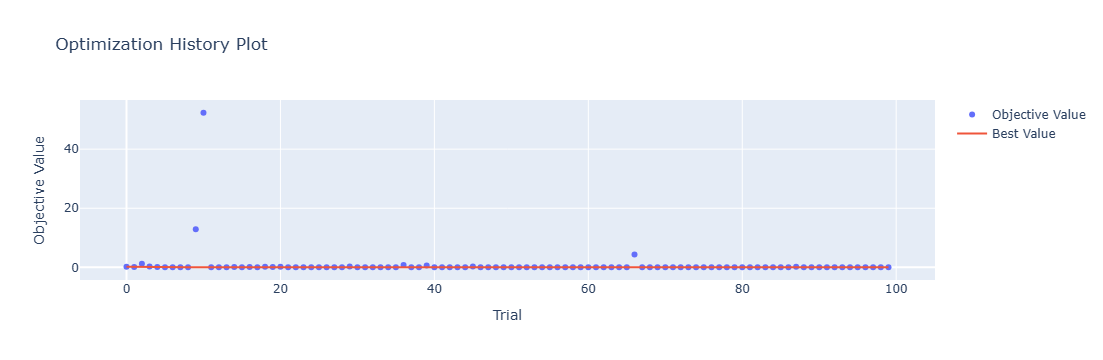

In [7]:
optuna.visualization.plot_optimization_history(study)

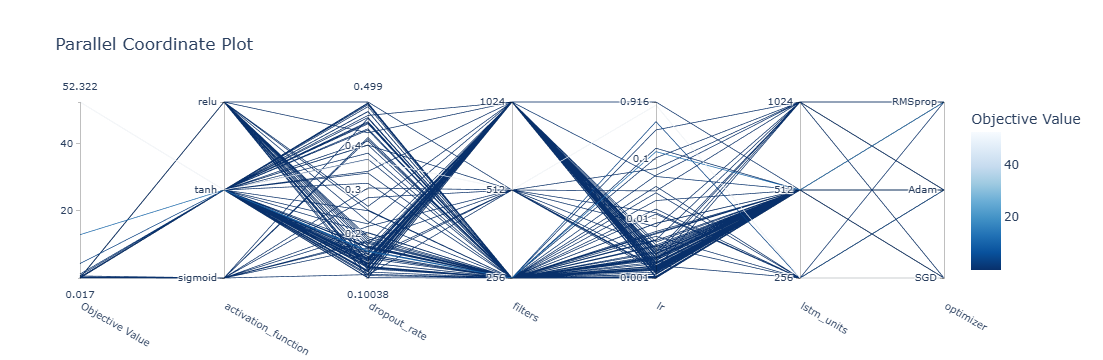

In [8]:
optuna.visualization.plot_parallel_coordinate(study)

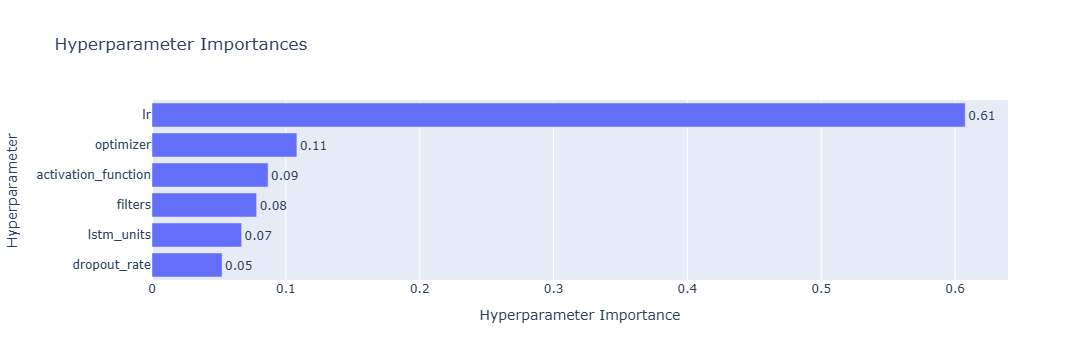

In [9]:
optuna.visualization.plot_param_importances(study)

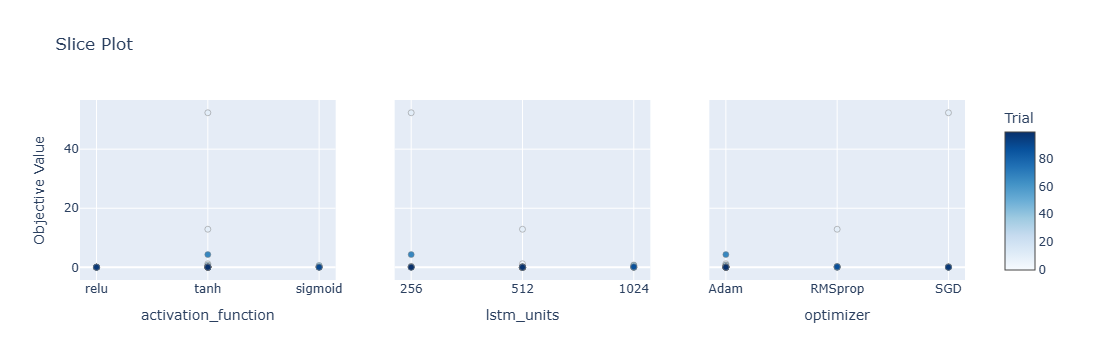

In [10]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

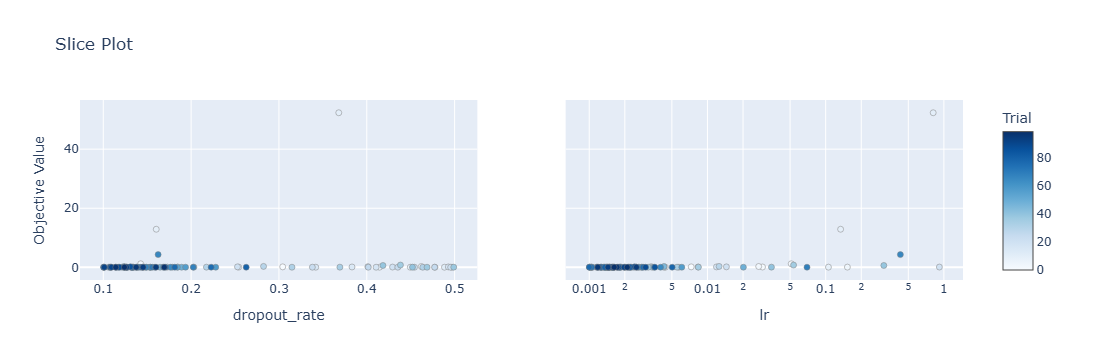

In [11]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[12.21  8.17 15.68 ... 23.86 20.59 15.82]
 [14.52 12.85 16.77 ... 26.49 23.17 21.15]
 [ 8.91  6.23 11.39 ... 22.62 16.72 14.05]
 ...
 [ 7.87  5.76 10.62 ... 21.07 15.24 12.04]
 [ 6.49  2.73  9.77 ... 21.93 16.5  11.44]
 [ 5.29  1.27  5.84 ... 22.11 15.37  9.87]]
Epoch 1/100
84/84 [==============================] - 8s 46ms/step - loss: 0.1558 - accuracy: 0.0000e+00 - mae: 0.1558 - rmse: 0.1558 - mape: 32.7692 - pearson: nan - val_loss: 0.1174 - val_accuracy: 0.0000e+00 - val_mae: 0.1174 - val_rmse: 0.1174 - val_mape: 26.3693 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 3s 32ms/step - loss: 0.0572 - accuracy: 0.0000e+00 - mae: 0.0572 - rmse: 0.0572 - mape: 12.0077 - pearson: nan - val_loss: 0.0344 - val_accuracy: 0.0000e+00 - val_mae: 0.0344 - val_rmse: 0.0344 - val_mape: 7.2584 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 3s 33ms/step - loss: 0.0463 - accuracy: 0.0000e+00 - mae: 0.0463 - rmse: 0.0463 - mape: 9.7100 - pearson: nan - 

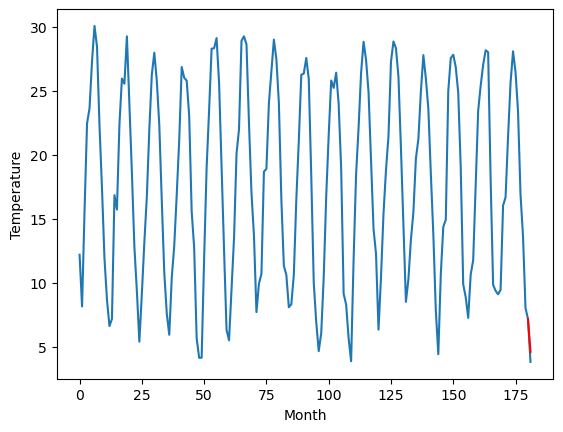

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.87		11.54		-1.33
[180, 181]
[13.23, 11.540890119075776]


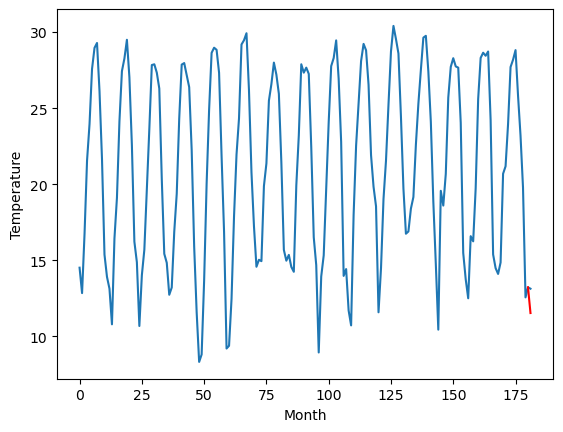

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
15.34		13.85		-1.49
[180, 181]
[7.18, 13.850890119075775]


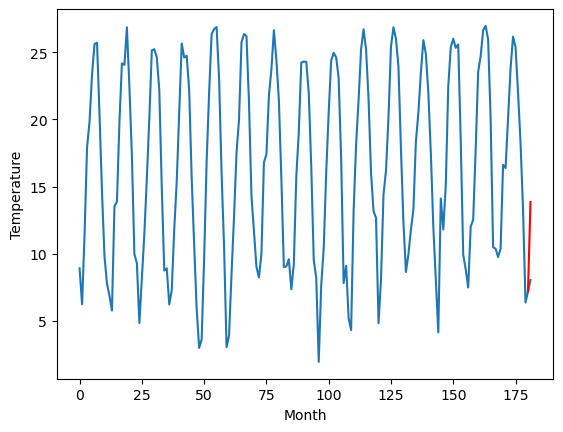

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.00		8.24		-0.76
[180, 181]
[11.46, 8.240890119075775]


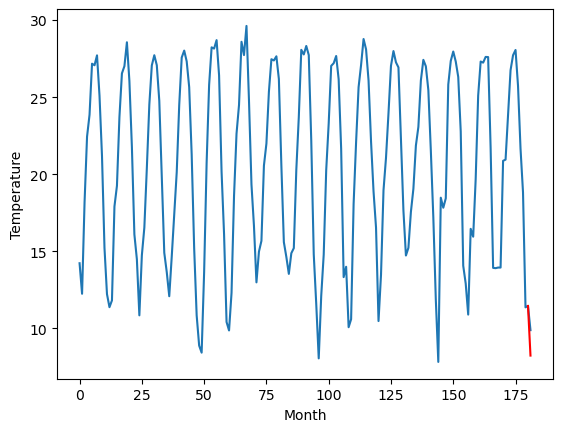

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.35		13.56		0.21
[180, 181]
[9.27, 13.560890119075776]


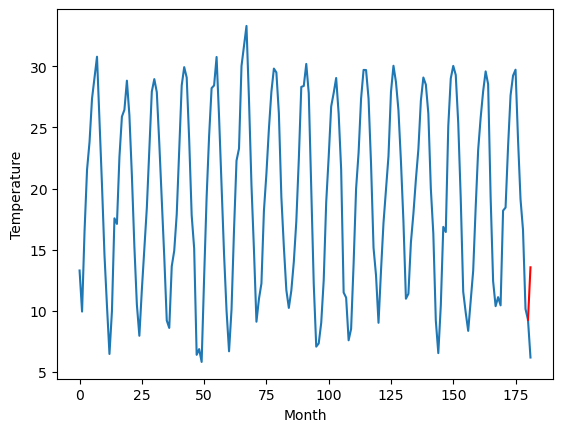

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.52		12.63		1.11
[180, 181]
[7.77, 12.630890119075776]


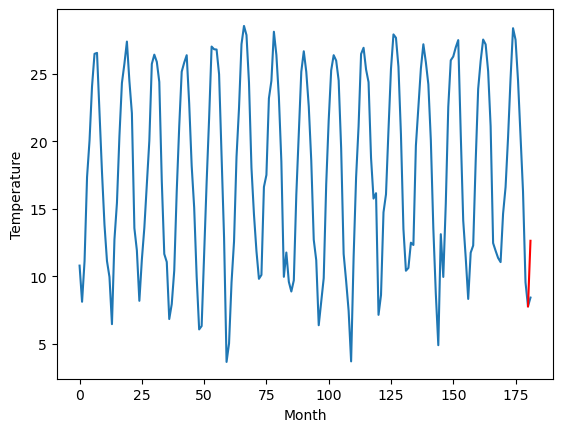

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.21		10.12		-0.09
[180, 181]
[6.59, 10.120889105796813]


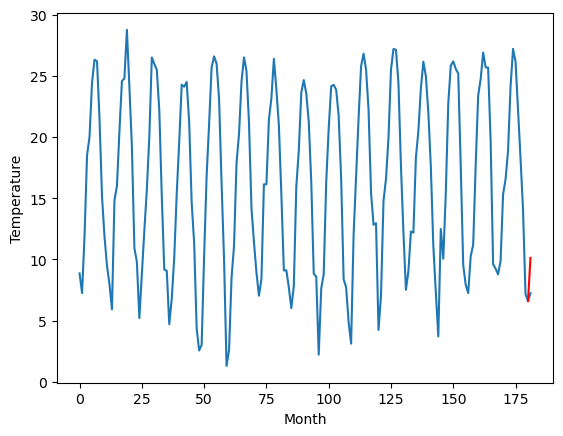

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.91		8.18		0.27
[180, 181]
[5.3, 8.180890119075775]


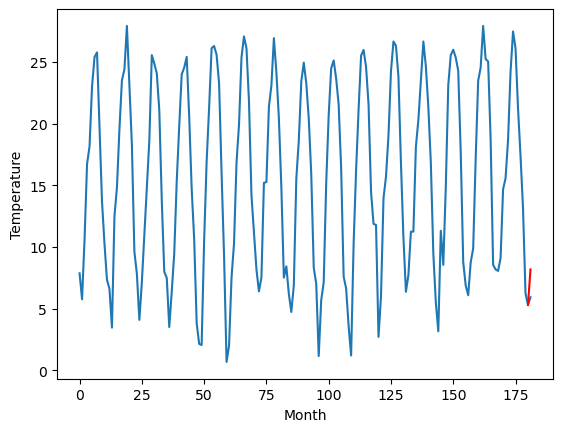

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.08		7.20		0.12
[180, 181]
[3.1, 7.200889105796814]


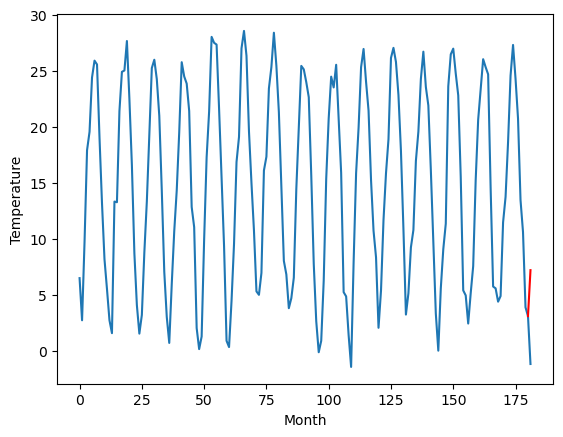

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
4.90		5.82		0.92
[180, 181]
[0.6, 5.820889105796814]


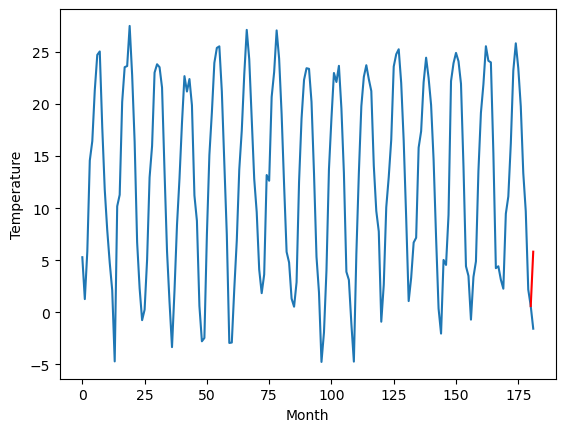

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
3.68		4.62		0.94
[180, 181]
[-0.75, 4.620890119075775]


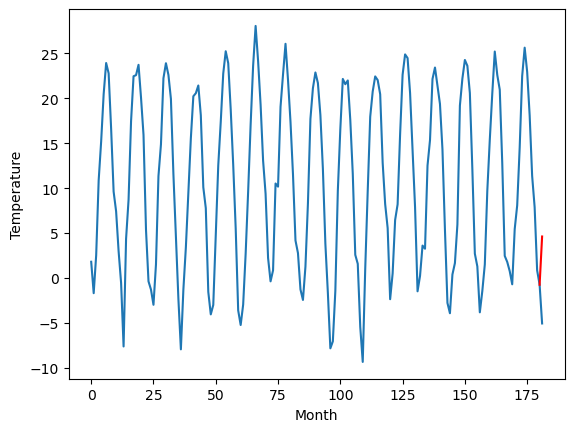

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    4.43   4.620890
1                 1   12.87  11.540890
2                 2   15.34  13.850890
3                 3    9.00   8.240890
4                 4   13.35  13.560890
5                 5   11.52  12.630890
6                 6   10.21  10.120889
7                 7    7.91   8.180890
8                 8    7.08   7.200889
9                 9    4.90   5.820889
10               10    3.68   4.620890


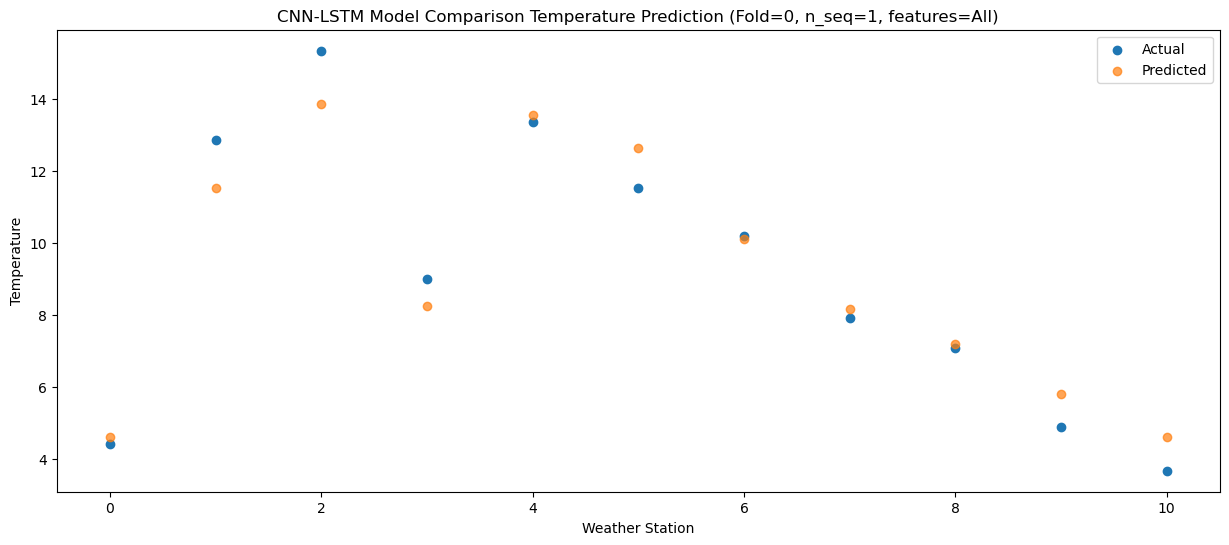

f, t:
[[ 4.43 12.87 15.34  9.   13.35 11.52 10.21  7.91  7.08  4.9   3.68]]
[[ 4.62089012 11.54089012 13.85089012  8.24089012 13.56089012 12.63089012
  10.12088911  8.18089012  7.20088911  5.82088911  4.62089012]]
Year at t+1:
t+1 SKRMSE: 0.836903
t+1 KRMSE: 0.836903
t+1 MAE: 0.675697
t+1 SKMAPE: 0.085788
t+1 R2_SCORE: 0.949522
t+1 KMAPE: 0.085788
t+1 PEARSON: 0.959594
t+1 AVERAGE ACTUAL: 9.117273
Metrics for this Fold:
SKRMSE: 0.836903
KRMSE: 0.836903
MAE: 0.675697
SKMAPE: 0.085788
R2_SCORE: 0.949522
KMAPE: 0.085788
PEARSON: 0.959594
AVERAGE ACTUAL: 9.117273
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 1024)           2200576   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 1024)          0         
 )                                                               
                  

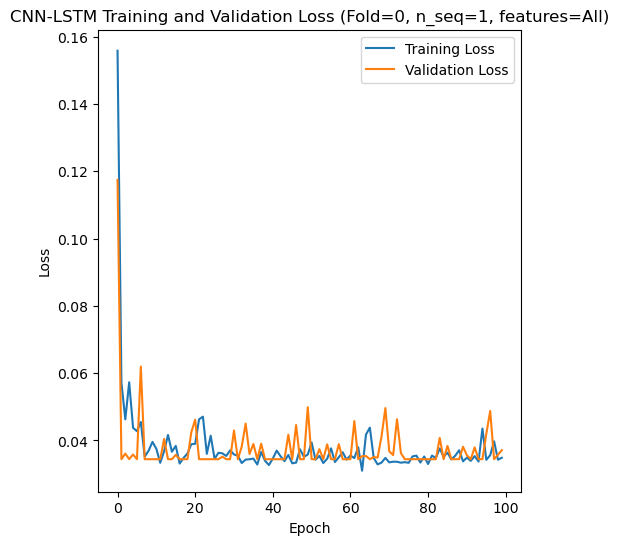

[[12.2  10.03 13.86 ... 24.46 19.58 17.03]
 [ 8.35  6.22 11.74 ... 22.47 18.02 13.98]
 [10.82  7.37 13.36 ... 24.57 19.57 16.15]
 ...
 [ 7.69  4.56 11.66 ... 25.3  19.83 13.28]
 [ 8.93  6.7  14.14 ... 25.37 21.51 12.55]
 [ 7.96  5.46 11.14 ... 25.13 20.28 10.63]]
Epoch 1/100
84/84 [==============================] - 24s 108ms/step - loss: 0.1241 - accuracy: 0.0000e+00 - mae: 0.1241 - rmse: 0.1241 - mape: 26.4085 - pearson: nan - val_loss: 0.0638 - val_accuracy: 0.0000e+00 - val_mae: 0.0638 - val_rmse: 0.0638 - val_mape: 13.9448 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 5s 54ms/step - loss: 0.0822 - accuracy: 0.0000e+00 - mae: 0.0822 - rmse: 0.0822 - mape: 17.5181 - pearson: nan - val_loss: 0.1132 - val_accuracy: 0.0000e+00 - val_mae: 0.1132 - val_rmse: 0.1132 - val_mape: 24.4598 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 5s 60ms/step - loss: 0.0674 - accuracy: 0.0000e+00 - mae: 0.0674 - rmse: 0.0674 - mape: 14.4161 - pearson: na

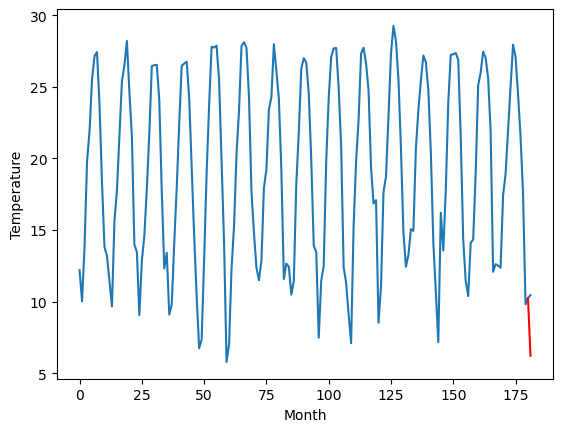

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.00		10.46		-1.54
[180, 181]
[6.41, 10.464272570610046]


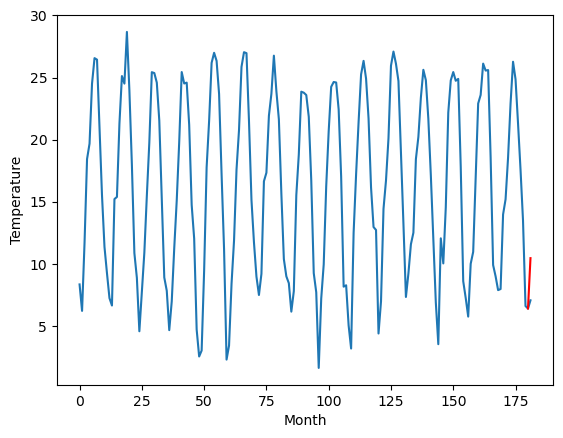

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.77		6.61		-2.16
[180, 181]
[7.6, 6.614272570610046]


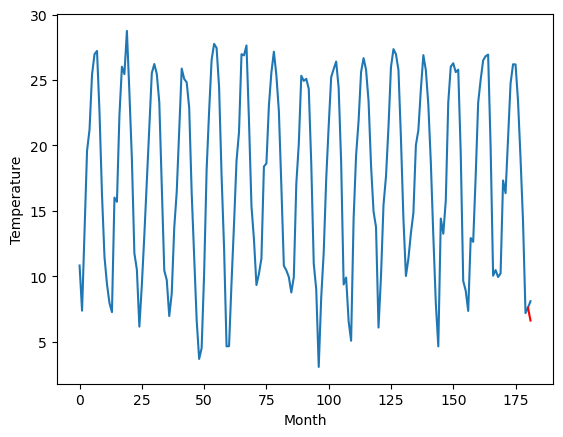

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.72		9.08		-1.64
[180, 181]
[11.89, 9.084272570610047]


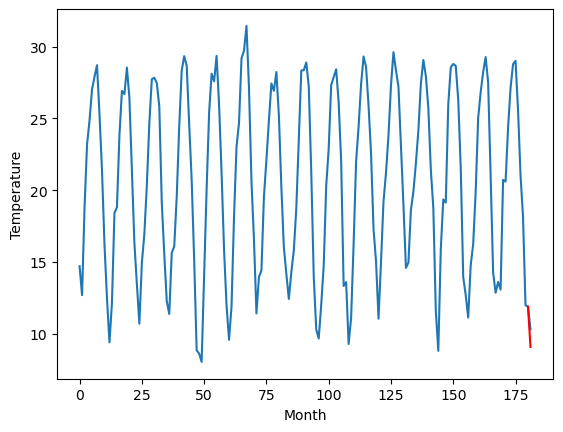

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.70		12.97		-1.73
[180, 181]
[10.96, 12.974272570610047]


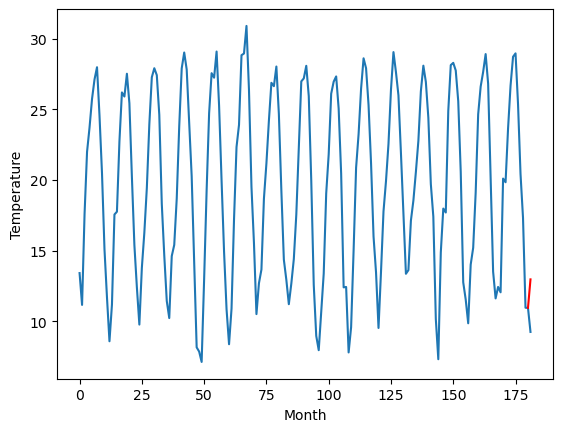

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.91		11.68		-0.23
[180, 181]
[7.75, 11.684272570610046]


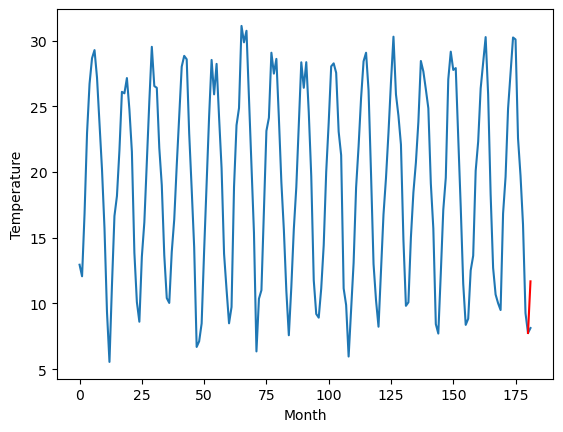

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.75		11.21		-1.54
[180, 181]
[6.17, 11.214272570610046]


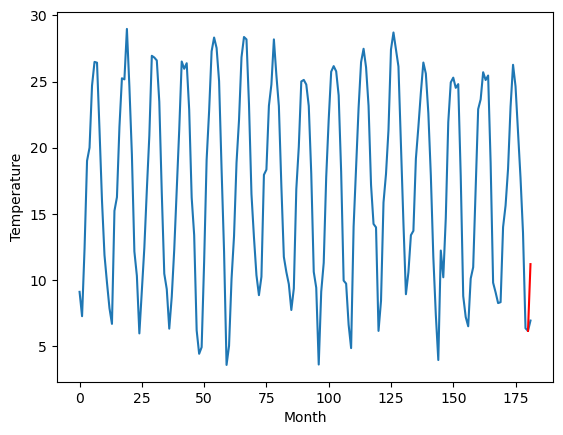

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.81		7.38		-1.43
[180, 181]
[4.57, 7.384272570610046]


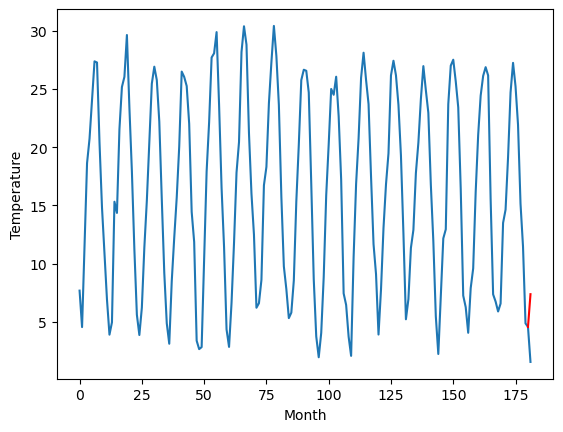

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.34		5.95		-1.39
[180, 181]
[5.46, 5.954272570610047]


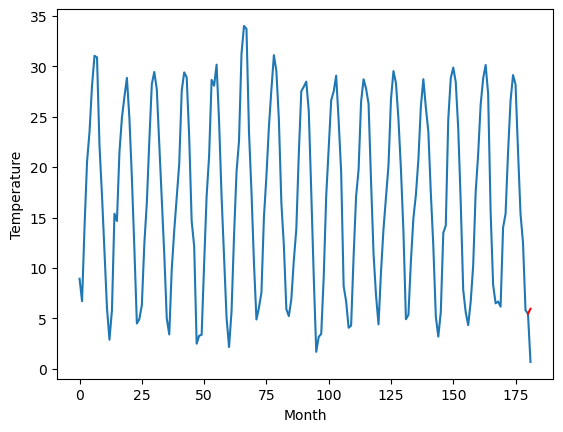

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.04		7.19		-1.85
[180, 181]
[5.42, 7.194270663261413]


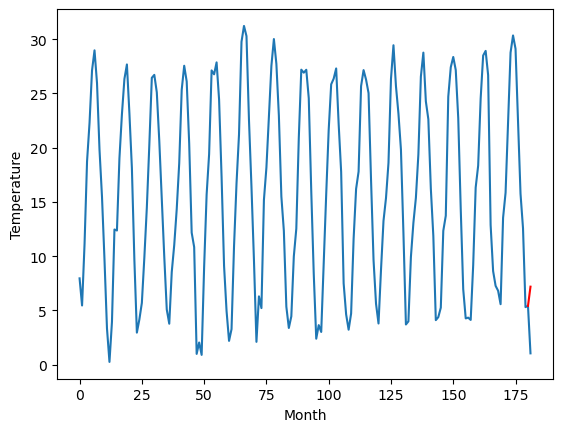

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.12		6.22		0.10
[180, 181]
[2.17, 6.224272570610046]


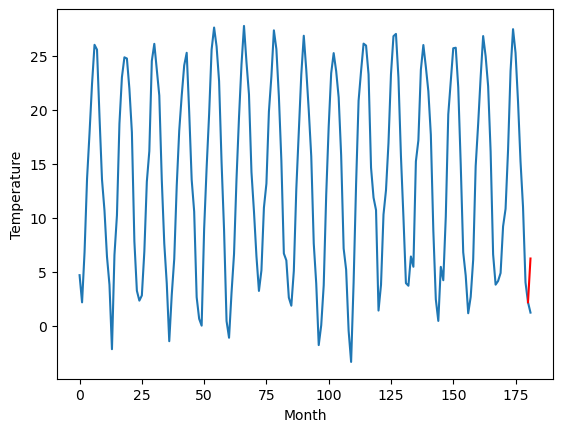

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    8.38   6.224273
1                 1   12.00  10.464273
2                 2    8.77   6.614273
3                 3   10.72   9.084273
4                 4   14.70  12.974273
5                 5   11.91  11.684273
6                 6   12.75  11.214273
7                 7    8.81   7.384273
8                 8    7.34   5.954273
9                 9    9.04   7.194271
10               10    6.12   6.224273


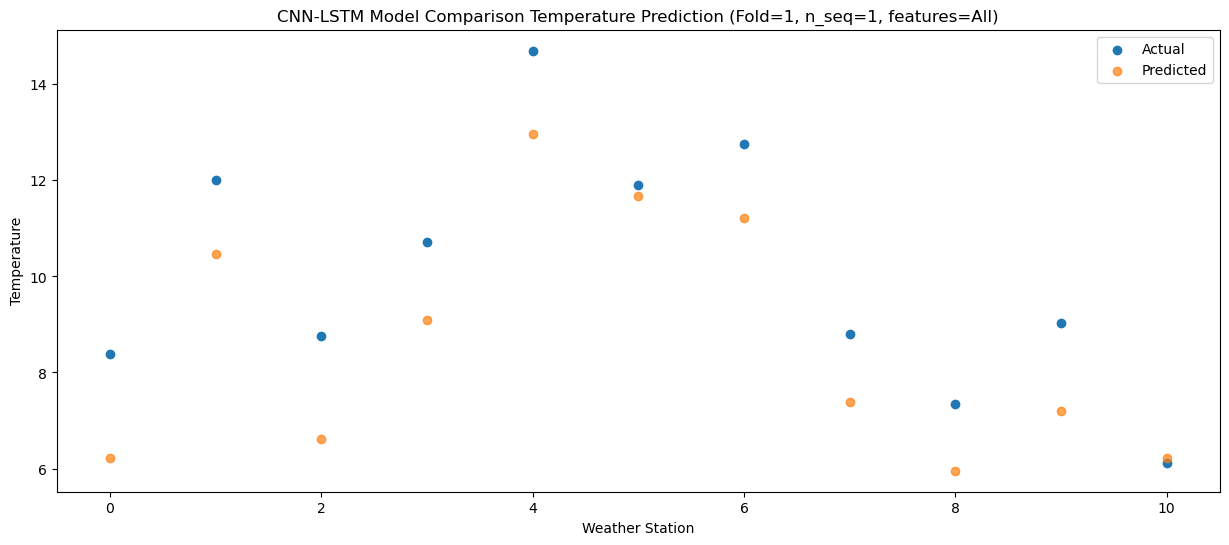

f, t:
[[ 8.38 12.    8.77 10.72 14.7  11.91 12.75  8.81  7.34  9.04  6.12]]
[[ 6.22427257 10.46427257  6.61427257  9.08427257 12.97427257 11.68427257
  11.21427257  7.38427257  5.95427257  7.19427066  6.22427257]]
Year at t+1:
t+1 SKRMSE: 1.569205
t+1 KRMSE: 1.569205
t+1 MAE: 1.430141
t+1 SKMAPE: 0.146568
t+1 R2_SCORE: 0.592056
t+1 KMAPE: 0.146568
t+1 PEARSON: 0.922746
t+1 AVERAGE ACTUAL: 10.049091
Metrics for this Fold:
SKRMSE: 1.569205
KRMSE: 1.569205
MAE: 1.430141
SKMAPE: 0.146568
R2_SCORE: 0.592056
KMAPE: 0.146568
PEARSON: 0.922746
AVERAGE ACTUAL: 10.049091
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 1024)           2200576   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 1024)          0         
 1D)                                                             
              

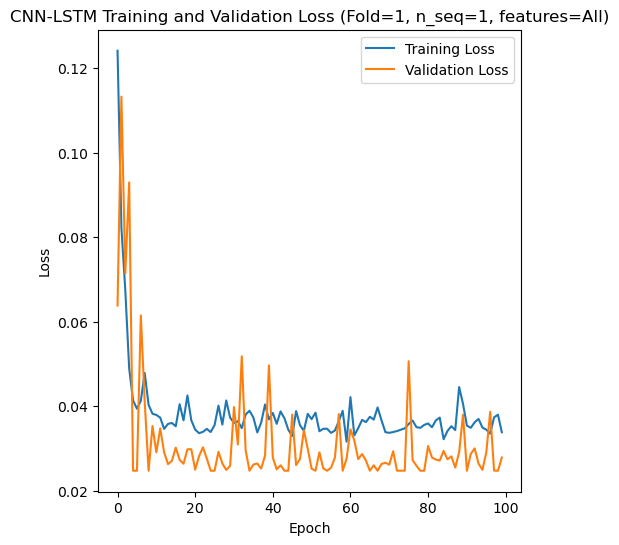

[[ 8.61  4.71 12.22 ... 22.49 18.22 13.52]
 [ 6.28  3.18  8.73 ... 22.36 17.39  7.52]
 [17.82 16.52 20.35 ... 28.79 25.32 22.93]
 ...
 [ 6.77  9.55 12.16 ... 24.55 20.29 10.24]
 [12.04 12.81 10.78 ... 23.32 20.33 13.93]
 [ 8.57  6.56 11.36 ... 21.36 16.14 12.65]]
Epoch 1/100
84/84 [==============================] - 53s 292ms/step - loss: 0.1400 - accuracy: 0.0000e+00 - mae: 0.1400 - rmse: 0.1400 - mape: 29.3322 - pearson: nan - val_loss: 0.0876 - val_accuracy: 0.0000e+00 - val_mae: 0.0876 - val_rmse: 0.0876 - val_mape: 19.4591 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 17s 204ms/step - loss: 0.0753 - accuracy: 0.0000e+00 - mae: 0.0753 - rmse: 0.0753 - mape: 15.8131 - pearson: nan - val_loss: 0.0207 - val_accuracy: 0.0000e+00 - val_mae: 0.0207 - val_rmse: 0.0207 - val_mape: 4.7502 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 17s 202ms/step - loss: 0.0557 - accuracy: 0.0000e+00 - mae: 0.0557 - rmse: 0.0557 - mape: 11.8018 - pearson:

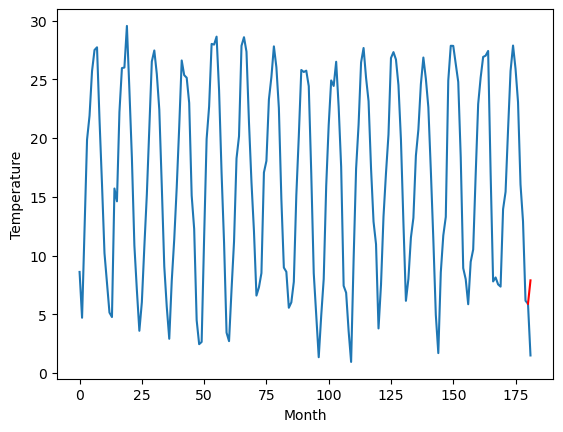

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.53		7.93		-0.60
[180, 181]
[2.63, 7.932808861732482]


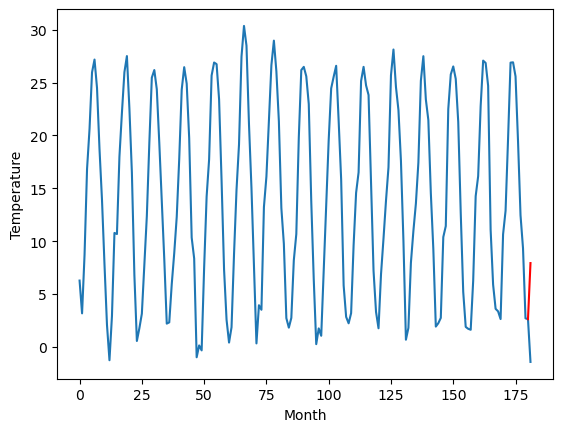

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.94		5.60		-1.34
[180, 181]
[16.55, 5.602808861732483]


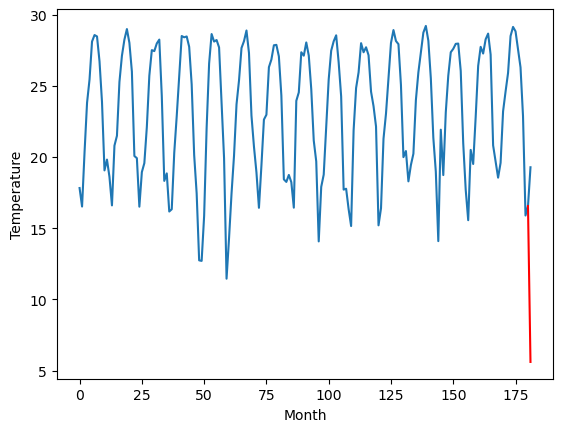

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.74		17.14		2.40
[180, 181]
[-0.83, 17.142808861732483]


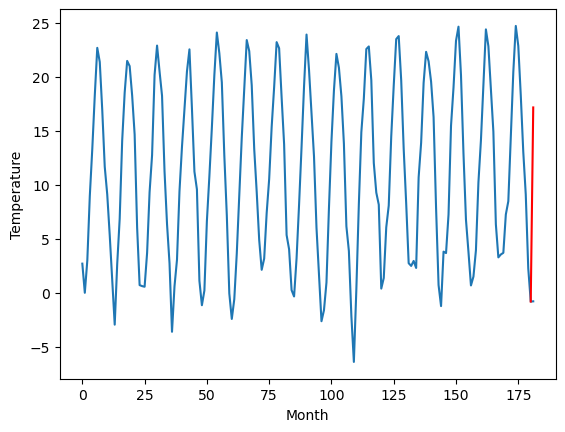

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
3.03		2.00		-1.03
[180, 181]
[11.52, 2.002808861732483]


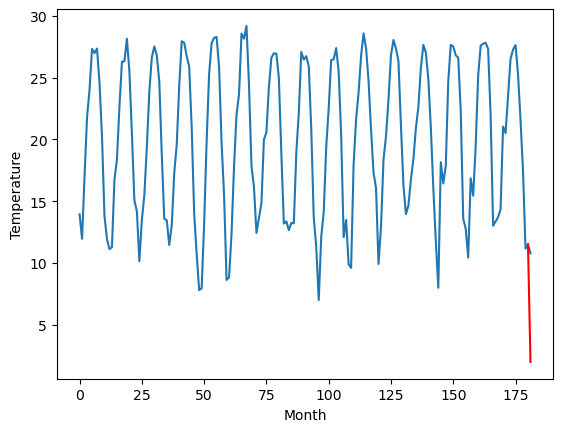

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.35		13.26		-0.09
[180, 181]
[11.47, 13.262808861732482]


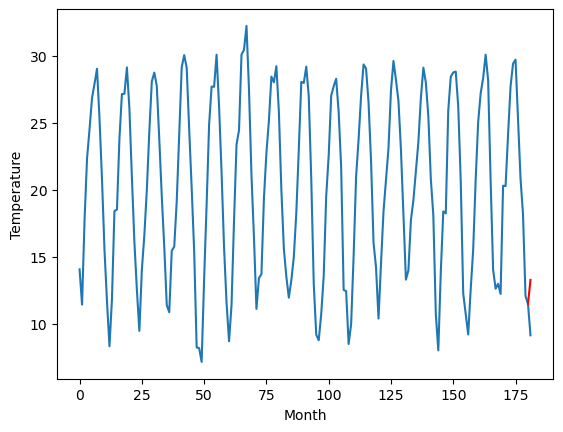

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.35		13.37		0.02
[180, 181]
[7.75, 13.372808861732484]


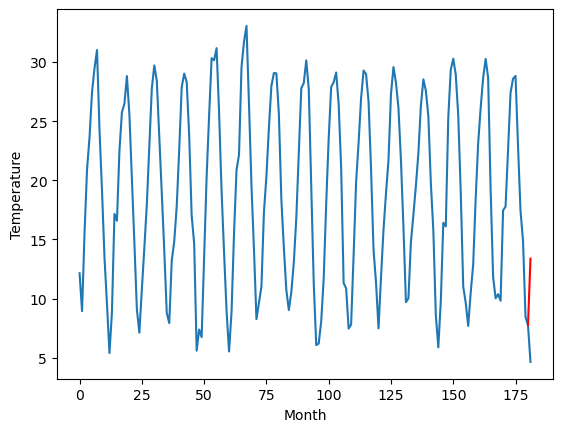

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.68		11.46		-1.22
[180, 181]
[4.9, 11.462808861732483]


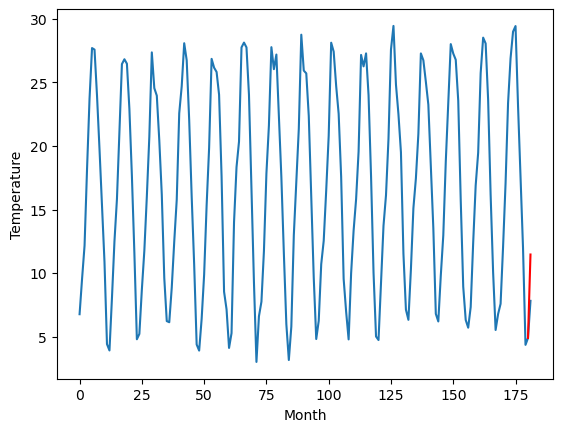

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.71		6.09		-0.62
[180, 181]
[14.14, 6.0928088617324825]


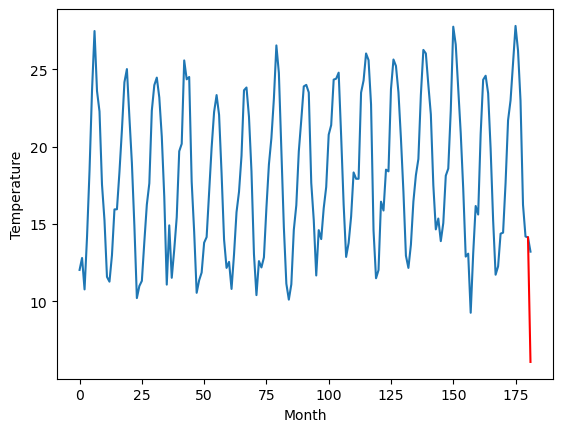

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.63		11.36		-0.27
[180, 181]
[5.55, 11.362808861732482]


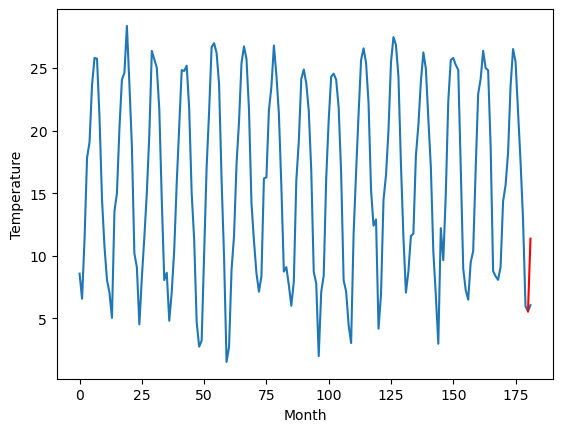

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.90		7.89		-1.01
[180, 181]
[3.19, 7.892808861732483]


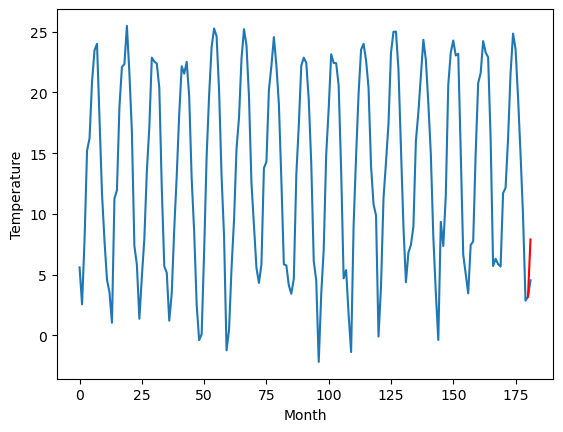

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    8.31   7.892809
1                 1    8.53   7.932809
2                 2    6.94   5.602809
3                 3   14.74  17.142809
4                 4    3.03   2.002809
5                 5   13.35  13.262809
6                 6   13.35  13.372809
7                 7   12.68  11.462809
8                 8    6.71   6.092809
9                 9   11.63  11.362809
10               10    8.90   7.892809


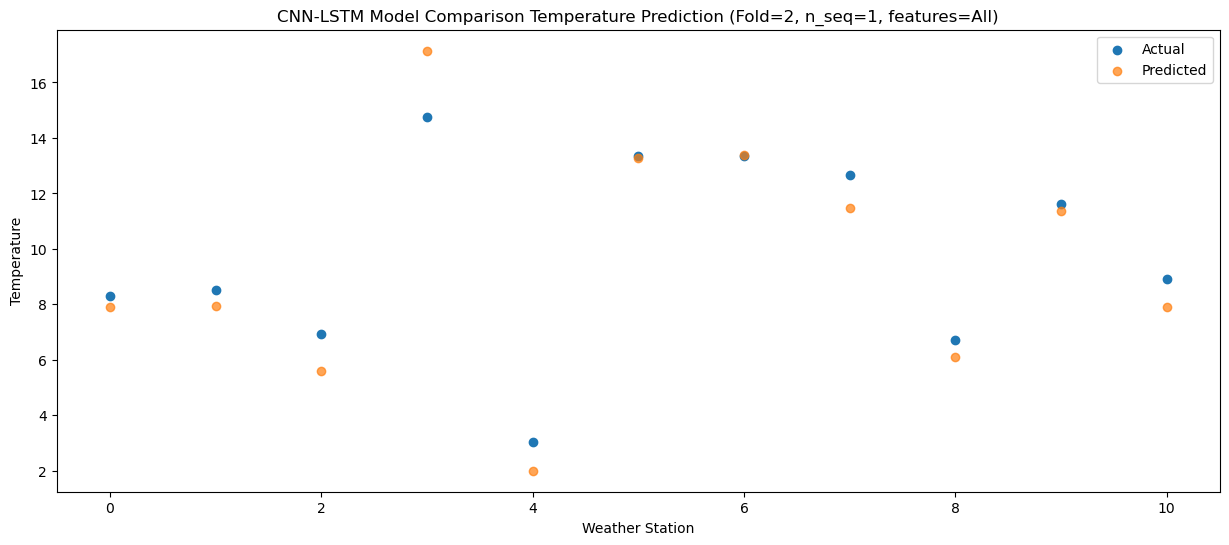

f, t:
[[ 8.31  8.53  6.94 14.74  3.03 13.35 13.35 12.68  6.71 11.63  8.9 ]]
[[ 7.89280886  7.93280886  5.60280886 17.14280886  2.00280886 13.26280886
  13.37280886 11.46280886  6.09280886 11.36280886  7.89280886]]
Year at t+1:
t+1 SKRMSE: 1.048974
t+1 KRMSE: 1.048974
t+1 MAE: 0.818213
t+1 SKMAPE: 0.104297
t+1 R2_SCORE: 0.906493
t+1 KMAPE: 0.104297
t+1 PEARSON: 0.964758
t+1 AVERAGE ACTUAL: 9.833636
Metrics for this Fold:
SKRMSE: 1.048974
KRMSE: 1.048974
MAE: 0.818213
SKMAPE: 0.104297
R2_SCORE: 0.906493
KMAPE: 0.104297
PEARSON: 0.964758
AVERAGE ACTUAL: 9.833636
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1, 1024)           2200576   
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 1024)          0         
 1D)                                                             
                

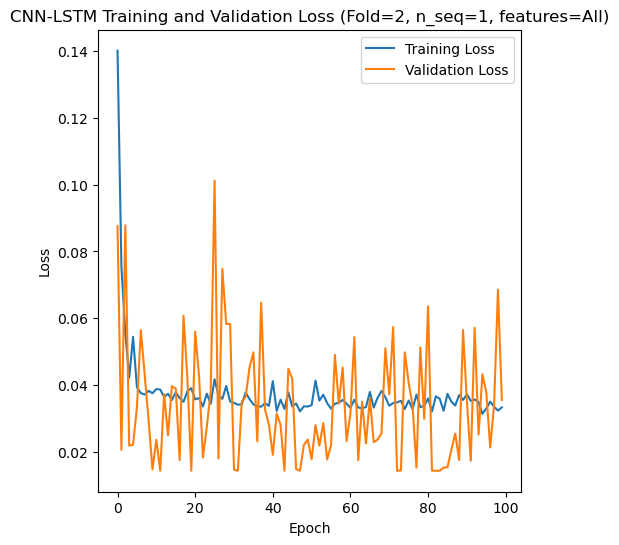

[[ 8.9   6.89 11.3  ... 22.19 16.88 13.54]
 [ 7.02  3.15 10.24 ... 22.31 18.92 11.32]
 [ 7.65  9.7   9.44 ... 25.68 20.65 11.46]
 ...
 [ 9.57 11.93 12.22 ... 30.9  25.01 12.37]
 [ 9.04  9.3   8.59 ... 17.72 17.26 10.73]
 [ 3.2   0.4   3.78 ... 18.92 14.39 10.04]]
Epoch 1/100
84/84 [==============================] - 51s 273ms/step - loss: 0.1308 - accuracy: 0.0000e+00 - mae: 0.1308 - rmse: 0.1308 - mape: 28.7578 - pearson: nan - val_loss: 0.0724 - val_accuracy: 0.0000e+00 - val_mae: 0.0724 - val_rmse: 0.0724 - val_mape: 16.5592 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 16s 186ms/step - loss: 0.0853 - accuracy: 0.0000e+00 - mae: 0.0853 - rmse: 0.0853 - mape: 19.0409 - pearson: nan - val_loss: 0.0409 - val_accuracy: 0.0000e+00 - val_mae: 0.0409 - val_rmse: 0.0409 - val_mape: 8.0919 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 16s 193ms/step - loss: 0.0537 - accuracy: 0.0000e+00 - mae: 0.0537 - rmse: 0.0537 - mape: 12.0518 - pearson:

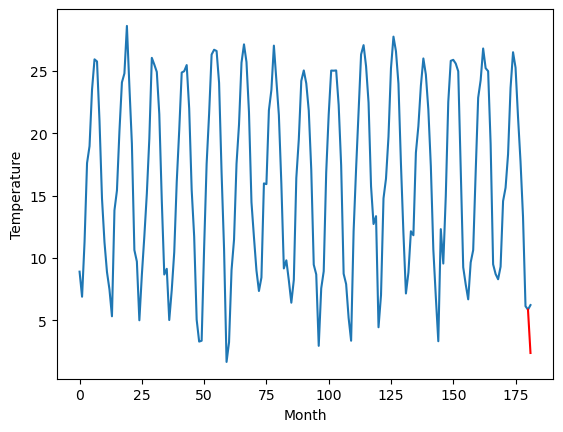

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.75		8.08		0.33
[180, 181]
[3.2, 8.076918625831604]


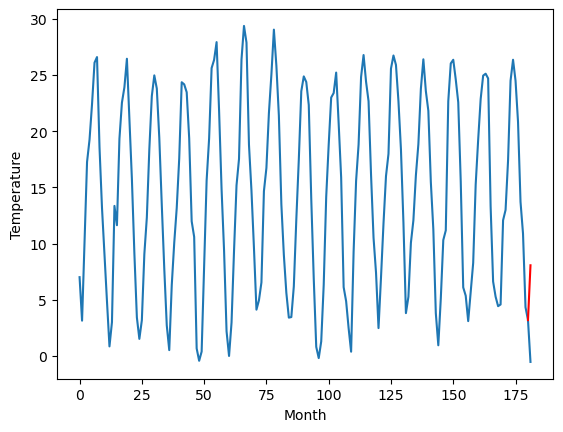

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.28		6.20		-2.08
[180, 181]
[8.48, 6.19691957950592]


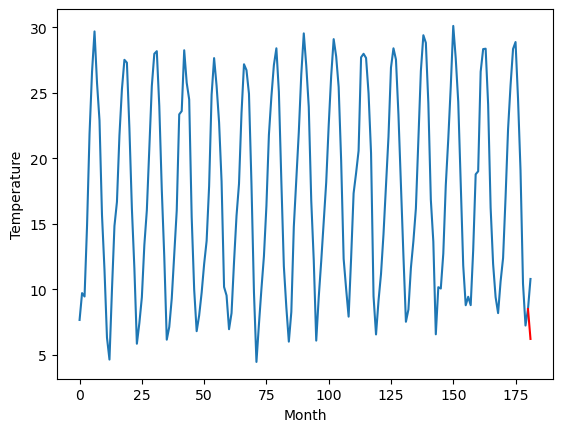

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.19		6.83		0.64
[180, 181]
[1.55, 6.826921486854554]


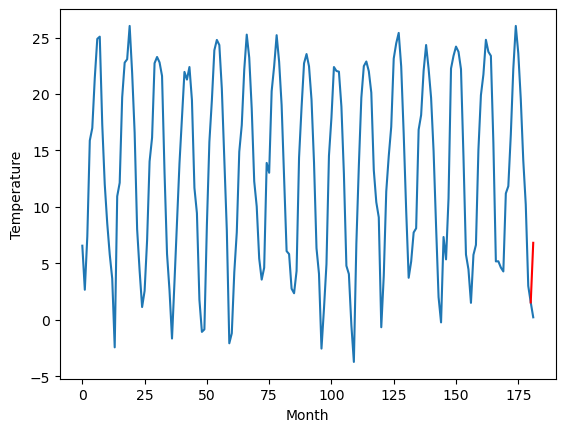

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.10		5.75		0.65
[180, 181]
[1.08, 5.746920533180237]


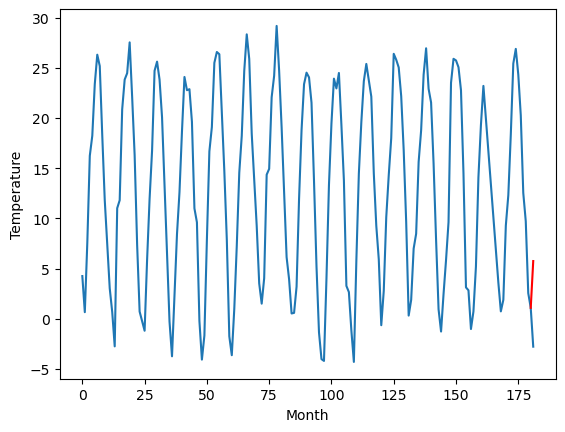

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.80		3.43		0.63
[180, 181]
[0.21, 3.4269195795059204]


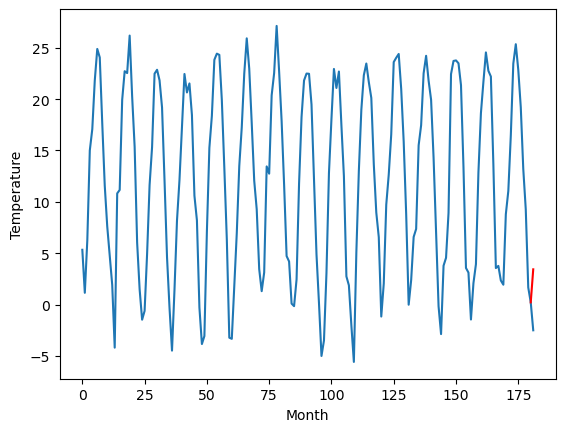

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.60		4.51		-1.09
[180, 181]
[-8.22, 4.506920533180237]


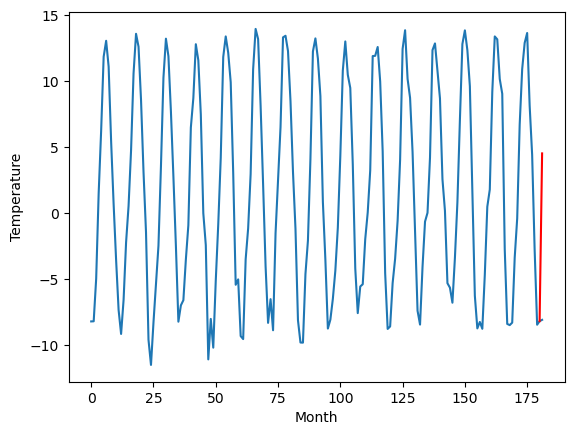

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
-7.69		-9.06		-1.37
[180, 181]
[10.04, -9.063081374168396]


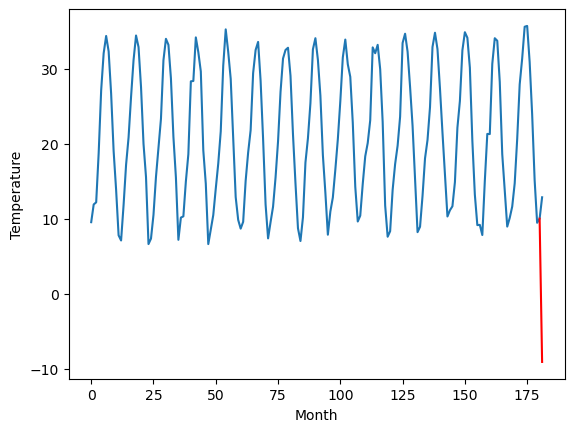

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.79		8.75		-2.04
[180, 181]
[9.17, 8.74691957950592]


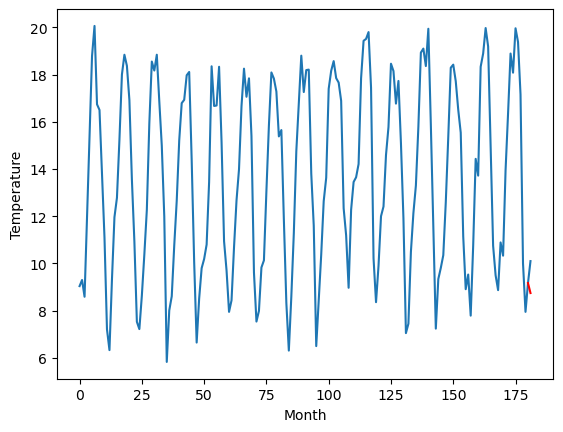

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.02		8.22		2.20
[180, 181]
[0.94, 8.21691957950592]


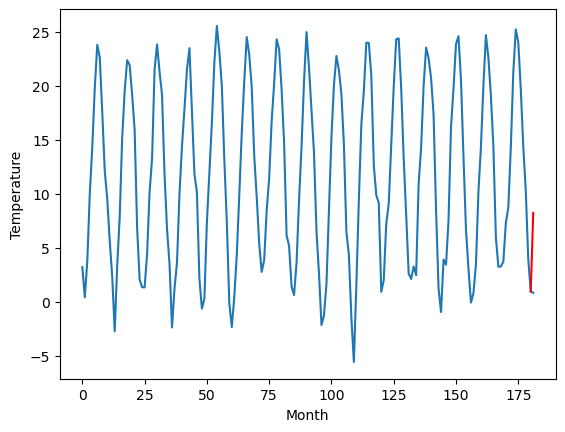

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
1.64		2.38		0.74
[180, 181]
[-0.13, 2.376920533180237]


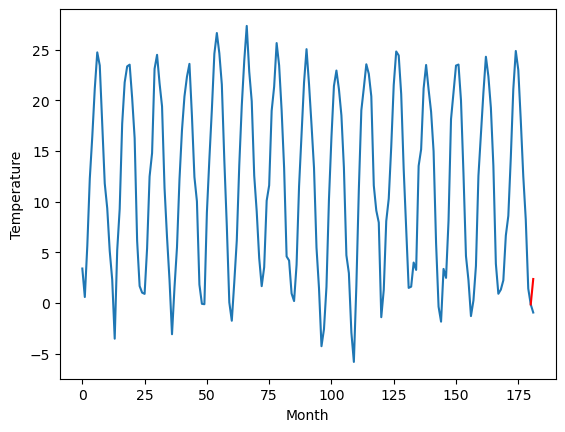

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    2.92   2.376921
1                 1    7.75   8.076919
2                 2    8.28   6.196920
3                 3    6.19   6.826921
4                 4    5.10   5.746921
5                 5    2.80   3.426920
6                 6    5.60   4.506921
7                 7   -7.69  -9.063081
8                 8   10.79   8.746920
9                 9    6.02   8.216920
10               10    1.64   2.376921


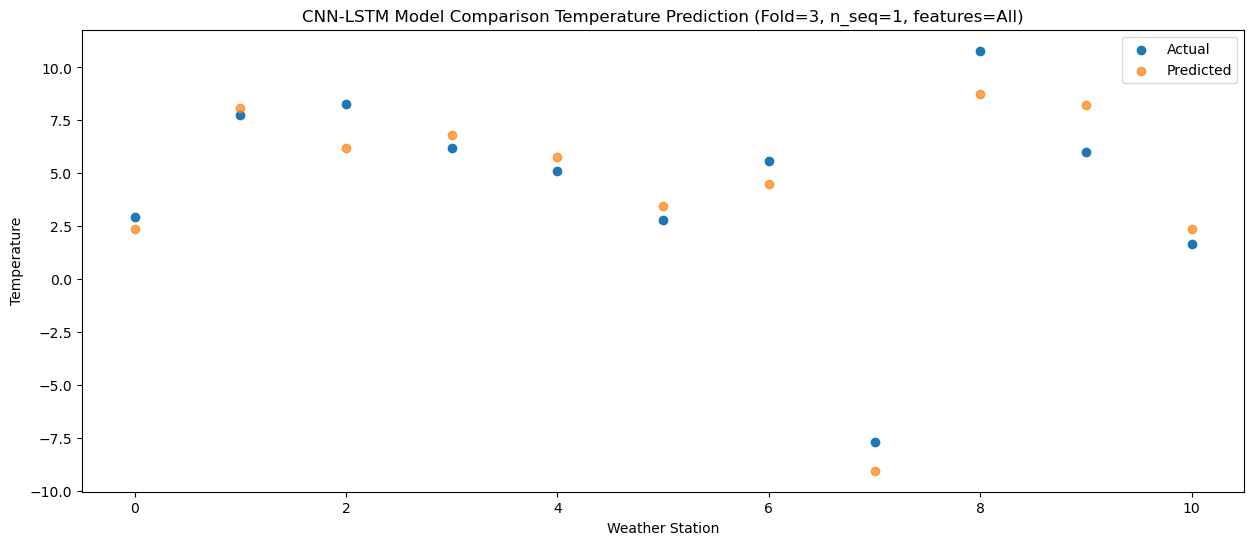

f, t:
[[ 2.92  7.75  8.28  6.19  5.1   2.8   5.6  -7.69 10.79  6.02  1.64]]
[[ 2.37692053  8.07691863  6.19691958  6.82692149  5.74692053  3.42691958
   4.50692053 -9.06308137  8.74691958  8.21691958  2.37692053]]
Year at t+1:
t+1 SKRMSE: 1.299724
t+1 KRMSE: 1.299724
t+1 MAE: 1.118811
t+1 SKMAPE: 0.210070
t+1 R2_SCORE: 0.920355
t+1 KMAPE: 0.177605
t+1 PEARSON: 0.926602
t+1 AVERAGE ACTUAL: 4.490909
Metrics for this Fold:
SKRMSE: 1.299724
KRMSE: 1.299724
MAE: 1.118811
SKMAPE: 0.210070
R2_SCORE: 0.920355
KMAPE: 0.177605
PEARSON: 0.926602
AVERAGE ACTUAL: 4.490909
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 1, 1024)           2200576   
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 1024)          0         
 1D)                                                             
                

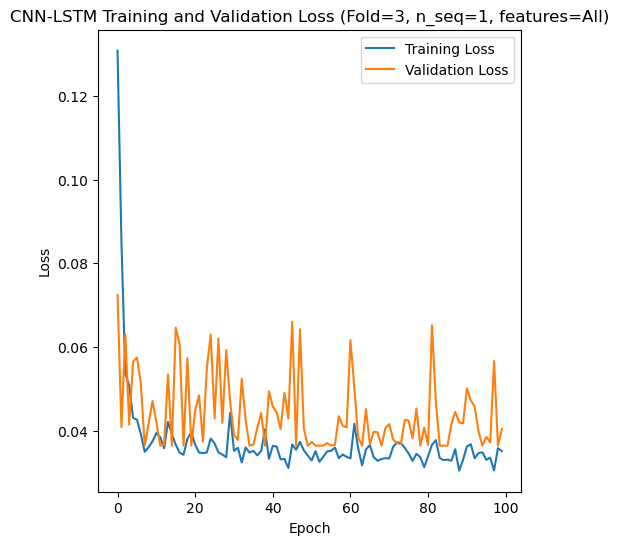

[[ 4.89  1.26  7.78 ... 22.59 18.46  9.82]
 [15.38 13.87 17.63 ... 26.66 22.89 20.2 ]
 [11.49  8.39 14.48 ... 24.97 20.83 17.82]
 ...
 [ 7.64  3.61 10.44 ... 21.3  17.62 11.34]
 [ 4.26  0.29  5.21 ... 21.47 15.54  9.34]
 [ 3.62 -0.32  6.05 ... 19.99 14.92  8.29]]
Epoch 1/100
84/84 [==============================] - 51s 285ms/step - loss: 0.1312 - accuracy: 0.0000e+00 - mae: 0.1312 - rmse: 0.1312 - mape: 27.7145 - pearson: nan - val_loss: 0.1797 - val_accuracy: 0.0000e+00 - val_mae: 0.1797 - val_rmse: 0.1797 - val_mape: 37.1515 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 16s 194ms/step - loss: 0.0795 - accuracy: 0.0000e+00 - mae: 0.0795 - rmse: 0.0795 - mape: 16.5900 - pearson: nan - val_loss: 0.0793 - val_accuracy: 0.0000e+00 - val_mae: 0.0793 - val_rmse: 0.0793 - val_mape: 18.7445 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 16s 195ms/step - loss: 0.0638 - accuracy: 0.0000e+00 - mae: 0.0638 - rmse: 0.0638 - mape: 13.3457 - pearson

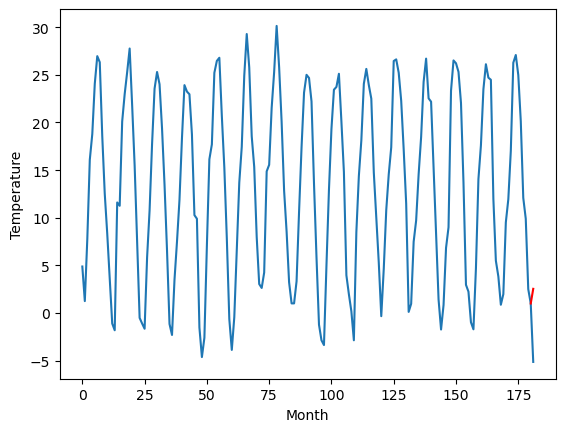

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.59		3.82		-1.77
[180, 181]
[14.25, 3.8181762838363644]


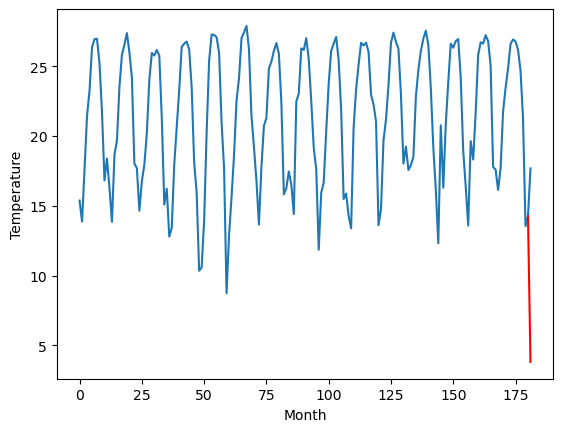

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
15.41		14.31		-1.10
[180, 181]
[9.06, 14.308178191184998]


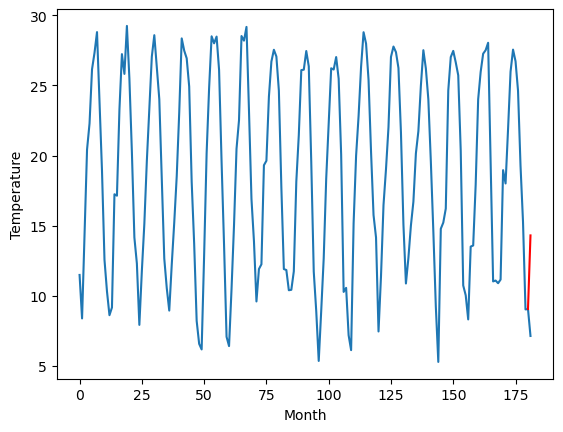

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.57		10.42		-0.15
[180, 181]
[7.48, 10.418176283836365]


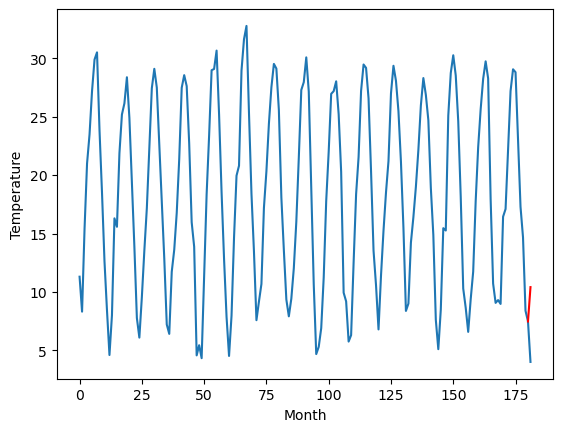

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.71		10.24		-0.47
[180, 181]
[7.33, 10.238176283836365]


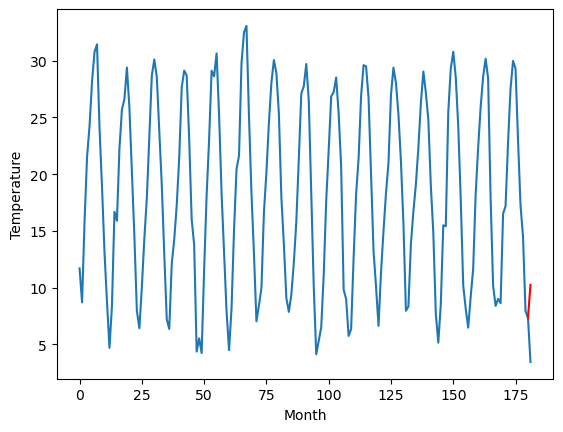

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.59		10.62		0.03
[180, 181]
[6.59, 10.618174257278442]


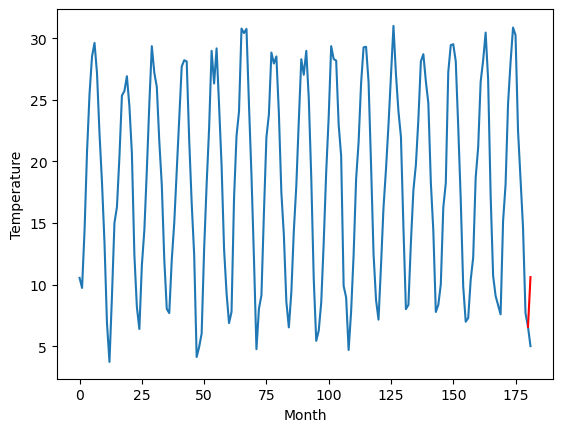

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.79		9.49		-1.30
[180, 181]
[6.04, 9.488176283836365]


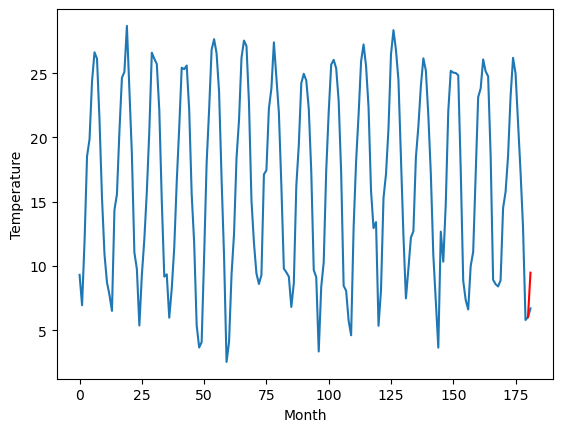

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.65		8.25		0.60
[180, 181]
[3.13, 8.248178191184998]


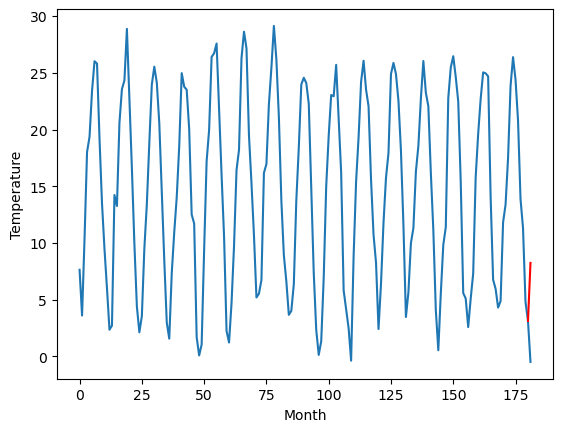

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.06		6.57		0.51
[180, 181]
[-0.29, 6.568176283836364]


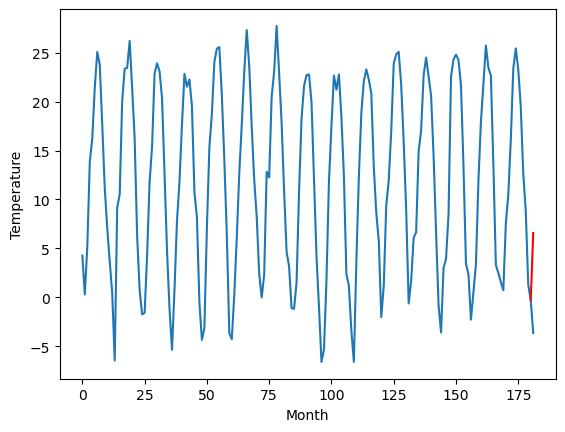

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.23		3.19		0.96
[180, 181]
[-1.03, 3.1881781911849973]


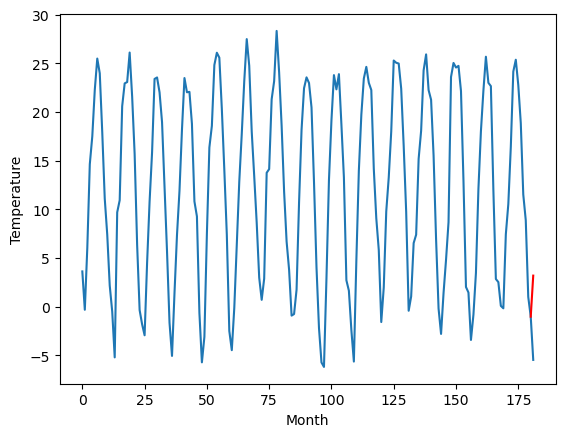

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
1.70		2.55		0.85
[180, 181]
[-2.29, 2.548176283836365]


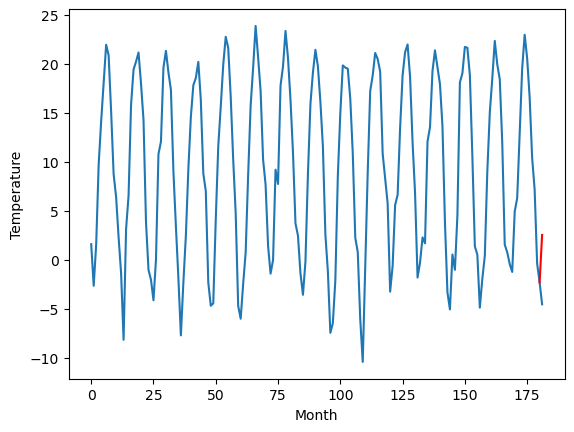

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    2.11   2.548178
1                 1    5.59   3.818176
2                 2   15.41  14.308178
3                 3   10.57  10.418176
4                 4   10.71  10.238176
5                 5   10.59  10.618174
6                 6   10.79   9.488176
7                 7    7.65   8.248178
8                 8    6.06   6.568176
9                 9    2.23   3.188178
10               10    1.70   2.548176


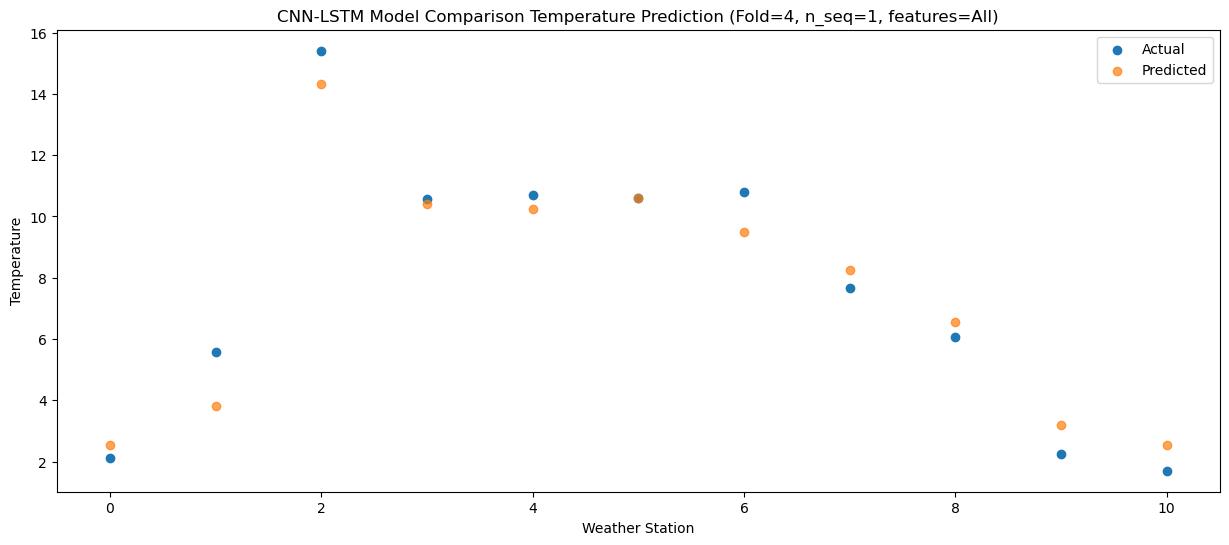

f, t:
[[ 2.11  5.59 15.41 10.57 10.71 10.59 10.79  7.65  6.06  2.23  1.7 ]]
[[ 2.54817819  3.81817628 14.30817819 10.41817628 10.23817628 10.61817426
   9.48817628  8.24817819  6.56817628  3.18817819  2.54817628]]
Year at t+1:
t+1 SKRMSE: 0.891380
t+1 KRMSE: 0.891380
t+1 MAE: 0.743471
t+1 SKMAPE: 0.169865
t+1 R2_SCORE: 0.956036
t+1 KMAPE: 0.169865
t+1 PEARSON: 0.964881
t+1 AVERAGE ACTUAL: 7.582727
Metrics for this Fold:
SKRMSE: 0.891380
KRMSE: 0.891380
MAE: 0.743471
SKMAPE: 0.169865
R2_SCORE: 0.956036
KMAPE: 0.169865
PEARSON: 0.964881
AVERAGE ACTUAL: 7.582727
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1, 1024)           2200576   
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1, 1024)          0         
 1D)                                                             
                

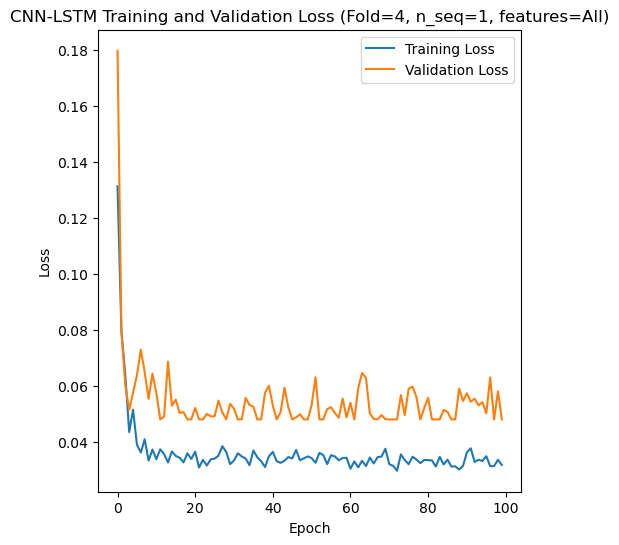

[[0.8369026774214294], [1.569205357542877], [1.048973728012419], [1.2997237030088804], [0.8913802515721965]]
[[array(0.83690268)], [array(1.56920536)], [array(1.04897373)], [array(1.2997237)], [array(0.89138025)]]
[[0.6756972130862156], [1.4301407974416556], [0.818212542533875], [1.1188110442595045], [0.7434707338159736]]
[[0.08578838159562531], [0.14656811809066317], [0.10429710477062121], [0.21006964660407698], [0.16986497499979553]]
[[0.949521941371658], [0.592055970418524], [0.906493208576033], [0.9203553879842966], [0.956036193167514]]
[[array(0.08578838)], [array(0.14656812)], [array(0.1042971)], [array(0.17760526)], [array(0.16986497)]]
[[array(0.95959444)], [array(0.9227457)], [array(0.96475756)], [array(0.9266019)], [array(0.96488052)]]
[ 4.43 12.87 15.34  9.   13.35 11.52 10.21  7.91  7.08  4.9   3.68  8.38
 12.    8.77 10.72 14.7  11.91 12.75  8.81  7.34  9.04  6.12  8.31  8.53
  6.94 14.74  3.03 13.35 13.35 12.68  6.71 11.63  8.9   2.92  7.75  8.28
  6.19  5.1   2.8   5.6  

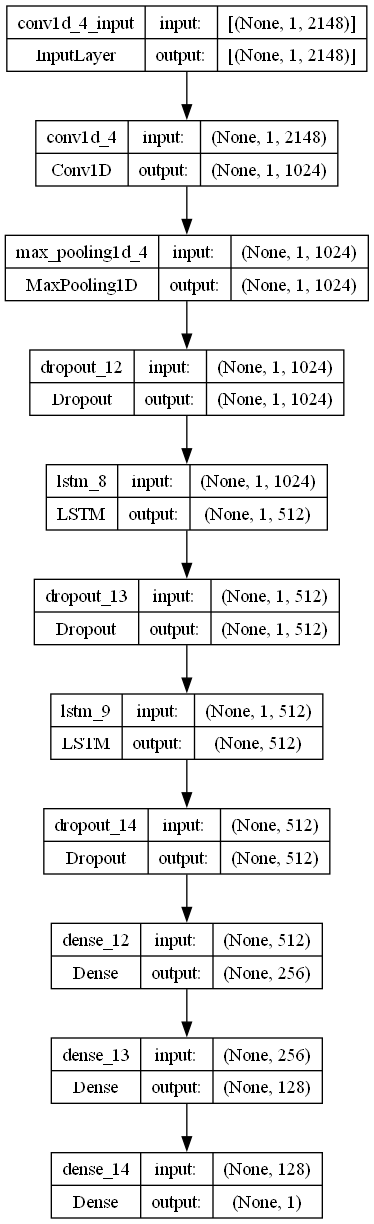

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 1024
    lr = 0.0013718815917713957
    optimizer = Adam(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 512
    dropout_rate = 0.13972977266384976

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))
    
    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()

    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_CV_S1.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)